# US Election 2020 Tweets

### The goal of the research: To explore the discourse and public opinion around the election across the USA states based on sentiment analysis and topic modelling.

*Team: Yuliia Nikolaenko, Mihaela Grigore, Lara Wagner *

Dataset: https://www.kaggle.com/manchunhui/us-election-2020-tweets
 
Story: We are part of the campaign management for Biden. We are trying to make Biden win the elections. We look at daily poll results to see when and where Biden is behind to inform us on how we need to change strategy.
Questions:  
- 1. in which states Biden is behind Trump (sentiment by state for the whole 3 weeks datasets)  
- 2. in the states where we want to attract people to our side:
    - a. what topics are they interestd in ? (cluster of 5-ish topics, % of discussion per topic per state) -> this tells us: people in state x are mostly takling about this topic 
    - b. are they happy or dissatisfied with that topic ? (sentiment analysis + topic analysis per country) -> this tells us: people in state x are mostly talking about thic topic and they are not happy about it => we need to includ in our discourse how we plan to improve that area   


## Table of Contents
1. Read and preprocess Data
2. Exploratory Data Analysis
3. Sentiment Analysis
4. Valency distribution of tweets over US States
5. Topic Modelling + Prediciton
6. Geographical Analysis over Topic and popularity


#### Columns are as follows:

**created_at:** Date and time of tweet creation  
**tweet_id:** Unique ID of the tweet    
**tweet:** Full tweet text  
**likes:** Number of likes  
**retweet_count:** Number of retweets   
**source:** Utility used to post tweet  
**user_id:** User ID of tweet creator   
**user_name:** Username of tweet creator    
**user_screen_name:** Screen name of tweet creator  
**user_description:** Description of self by tweet creator  
**user_join_date:** Join date of tweet creator  
**user_followers_count:** Followers count on tweet creator  
**user_location:** Location given on tweet creator's profile    
**lat:** Latitude parsed from user_location  
**long:** Longitude parsed from user_location   
**city:** City parsed from user_location    
**country:** Country parsed from user_location  
**state:** State parsed from user_location  
**state_code:** State code parsed from user_location    
**collected_at:** Date and time tweet data was mined from twitter*  

In [ ]:
# numerical computation
import numpy as np

# data processing/manipulation
import pandas as pd
pd.options.mode.chained_assignment = None
import re
from unidecode import unidecode 
from pprint import pprint
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
from collections import Counter
import math

# data visualization
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import gridspec
%matplotlib inline
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import plotly.express as px
import seaborn as sns

# stopwords, tokenizer, stemmer
import nltk  
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.probability import FreqDist
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer 
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

# spell correction, lemmatization
from textblob import TextBlob
from textblob import Word

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.corpora import Dictionary 
from gensim.models.ldamodel import LdaModel
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.parsing.preprocessing import STOPWORDS
from gensim.parsing.preprocessing import remove_stopwords

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

# spacy for lemmatization and additional stopwords
import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()
from spacy.lang.en.stop_words import STOP_WORDS

# LDA plotting tools
import pyLDAvis
import pyLDAvis.gensim
import pyLDAvis.sklearn 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
2021-07-30 10:09:56.800001: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-07-30 10:09:56.800062: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## 1. Read and preprocess Data

In [ ]:
# Loading each dataset
trump_df = pd.read_csv('hashtag_donaldtrump.csv/hashtag_donaldtrump.csv', lineterminator='\n')
biden_df = pd.read_csv('hashtag_joebiden.csv/hashtag_joebiden.csv', lineterminator='\n')

In [ ]:
pd.options.display.max_colwidth = 1000

In [ ]:
print('Total number of records in Trump dataset: ', trump_df.shape)
print('Total number of records in Biden dataset: ', biden_df.shape)

Total number of records in Trump dataset:  (970919, 21)
Total number of records in Biden dataset:  (776886, 21)


In [ ]:
# Getting some insights on trump_df dataset 
trump_df.describe()

In [ ]:
# Remove unneeded columns
#irrelevant_columns = ['tweet_id','user_id','user_name','user_screen_name','user_description','user_join_date','collected_at']

#a more conservative way of considering which columns are not relevant
#irrelevant_columns = ['collected_at']
irrelevant_columns = ['user_name','user_screen_name','user_description','user_join_date','collected_at']
trump_df = trump_df.drop(columns=irrelevant_columns)
biden_df = biden_df.drop(columns=irrelevant_columns)

# Renaming columns
trump_df = trump_df.rename(columns={"likes": "Likes", "retweet_count": "Retweets", 
                                    "state": "State", "user_followers_count": "Followers"})
biden_df = biden_df.rename(columns={"likes": "Likes", "retweet_count": "Retweets", 
                                    "state": "State", "user_followers_count": "Followers"})

# Update United States country name for consistency
d = {"United States of America":"United States"}
trump_df['country'].replace(d, inplace=True)
biden_df['country'].replace(d, inplace=True)

trump_df = trump_df.loc[trump_df['country'] == "United States"]
biden_df = biden_df.loc[biden_df['country'] == "United States"]

# Drop null rows
trump_df = trump_df.dropna()
biden_df = biden_df.dropna()

In [ ]:
# Filter on tweets that are within the Unites States
trump_usa_df = trump_df[trump_df['country'] == 'United States']
biden_usa_df = biden_df[biden_df['country'] == 'United States']

In [ ]:
del trump_df
del biden_df

In [ ]:
print('Total number of records in Trump dataset in USA only: ', trump_usa_df.shape)
print('Total number of records in Biden dataset in USA only: ', biden_usa_df.shape)

Total number of records in Trump dataset in USA only:  (101953, 16)
Total number of records in Biden dataset in USA only:  (90639, 16)


In [ ]:
trump_usa_df['initial_dataset'] = 'trump'
biden_usa_df['initial_dataset'] = 'biden'

# Combine the filtered on United States Trump and Biden Datasets 
twitter_usa_df = pd.concat([trump_usa_df,biden_usa_df],ignore_index=True)

# Get duplicates
twitter_usa_df_duplicates = twitter_usa_df[twitter_usa_df.duplicated(['tweet_id'], keep=False)]

#remove tweets with these ids from trump_usa_df and biden_usa_df
trump_usa_df = trump_usa_df[~trump_usa_df.tweet_id.isin(twitter_usa_df_duplicates.tweet_id)]
biden_usa_df = biden_usa_df[~biden_usa_df.tweet_id.isin(twitter_usa_df_duplicates.tweet_id)]

# Drop duplicates of tweets that relate to trump and biden 
twitter_usa_df.drop_duplicates(subset ="tweet_id", keep = False, inplace = True) #we remove them completely

# Check number of rows in combined dataset
twitter_usa_df.shape

(152376, 17)

Let's use a single dataset which contains the tweets from Biden dataset, as well as from the Trump dataset.
And keep track of the original dataset by setting the column 'initial_dataset'

In [ ]:
print('Trump: ', sum(twitter_usa_df.initial_dataset == 'trump'))
print('Biden: ', sum(twitter_usa_df.initial_dataset == 'biden'))

Trump:  81884
Biden:  70492


## 2. Exploratory Data Analysis

### Preprocessing Tweets
- lowercasing
- remove links, special char, punctuation ...
- Tokenisation
- stopword removal

In [ ]:
'''
Helper function that:
    - removes accents
    - removes stopwords
    - removes punctuation
    - remove all 1 and 2 letter 'words' that we create after automatic removal of the apostrophe character
'''

def clean_text(text):
    
    # remove accents of text
    text=unidecode(text)
    
    # lowercase
    text=text.lower()
    
    text=re.sub(r'&amp;',' ',text) # remove ampersand 
    #text=re.sub(r'[^\sa-zA-Z0-9@\[\]]',' ',text) # remove characters: punctuation and other special characters, except for: alphabet letters, numbers, '@' and '\' 
    
    text=re.sub(r'@[A-Za-z0-9]+','',text) #remove mentions of other twitter accounts (remove the whole user name)
    text=re.sub(r'#','',text) # remove the hashtag symbol (but leaves the hashtag word)
    text=re.sub(r'RT[\s]+','',text)
    text=re.sub(r'https?:\/\/\S+','',text) # removes hyperlinks
    text=re.sub(r'[^\w]', ' ', text)

    # remove stopwords
    text=remove_stopwords(text)
    
    text = re.sub(r'@\S+', "", text)    #remove all @name (mentions of other Twitter usernames) -> remove again mentioned of other usernames ?
    text = re.sub(r"http\S+", "", text) #remove all URLs (the whole URL, until the next ' ' is encountered) -> remove again all URL ?

    '''
    remove the names of the predicental candidates from the tweets
    by removing words that start with: [donal, trum, donaldtrump] or with [jo, bide, joebide]
    '''
    text = re.sub(r"donal\S+", " ", text) 
    text = re.sub(r"trum\S+", " ", text)
    text = re.sub(r"donaldtrum\S+", " ", text)
    text = re.sub(r"jo\S+", " ", text)    
    text = re.sub(r"bide\S+", " ", text)
    text = re.sub(r"joebide\S+", " ", text)
    text = re.sub(r"vot\S+", " ", text)
    text = re.sub(r"electio\S+", " ", text)
    
    '''
    remove any 1 or 2 letter entities that remain in a text after automatically removing the apostrophes 
    [d, f, i, m, s, t, u, y]
    [el, en, la, ll, pa, ve]
    '''
    text = re.sub(r"\sd\s", " ", text)
    text = re.sub(r"\sf\s", " ", text)
    text = re.sub(r"\si\s", " ", text)
    text = re.sub(r"\sm\s", " ", text)
    text = re.sub(r"\ss\s", " ", text)
    text = re.sub(r"\st\s", " ", text)
    text = re.sub(r"\su\s", " ", text)
    text = re.sub(r"\sy\s", " ", text)    
    text = re.sub(r"\sel\s", " ", text)
    text = re.sub(r"\sen\s", " ", text)
    text = re.sub(r"\sla\s", " ", text)
    text = re.sub(r"\sll\s", " ", text)
    text = re.sub(r"\spa\s", " ", text)    
    text = re.sub(r"\sve\s", " ", text)
    

    return text

In [ ]:
lemmatizer = WordNetLemmatizer()

# function to convert nltk tag to wordnet tag
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None
        
# Lemmatization function
def lemmatize_sentence(sentence):
    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))  
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:        
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

In [ ]:
# Tokenize Tweets 
def tokenize_text(tweet):
    filtered_tweet = []
    words = word_tokenize(tweet) 

    for word in words:
        filtered_tweet.append(word)
                
    return filtered_tweet


In [ ]:
# Cleaning all trump and biden tweets by applying clean_text()
trump_usa_df['cleaned_tweet'] = trump_usa_df.tweet.apply(lambda x: clean_text(x))
biden_usa_df['cleaned_tweet'] = biden_usa_df.tweet.apply(lambda x: clean_text(x))
twitter_usa_df['clean_tweets'] = twitter_usa_df['tweet'].apply(lambda x: clean_text(x))

'''
if you want to compare the original and 
the cleaned text to see what exactly was removed 
uncomment both lines below
'''
#pd.options.display.max_colwidth = 300
#print(twitter_usa_df[['tweet', 'cleaned_tweet']].head(10))

'\nif you want to compare the original and \nthe cleaned text to see what exactly was removed \nuncomment both lines below\n'

In [ ]:
# lemmatazing the  tweets by applying lemmatize_sentence()
trump_usa_df['lemmat_tweet'] = trump_usa_df.cleaned_tweet.apply(lambda x: lemmatize_sentence(x))
biden_usa_df['lemmat_tweet'] = biden_usa_df.cleaned_tweet.apply(lambda x: lemmatize_sentence(x))
twitter_usa_df['lemmat_tweets'] = twitter_usa_df.clean_tweets.apply(lambda x: lemmatize_sentence(x))

In [ ]:
twitter_usa_df['tokenized_tweets'] = twitter_usa_df.lemmat_tweets.apply(lambda x: tokenize_text(x))

## 2.1 Word frequency analysis

In [ ]:
list_text = []
for string in twitter_usa_df['lemmat_tweets']:
    list_text.append(string)
list_text

str_text = str(list_text)

#tokenization
txt_tokens = word_tokenize(str_text)
txt_tokens = [word.lower() for word in txt_tokens if word.isalpha()]

In [ ]:
# Frequency Distribution Plot
fdist = FreqDist(txt_tokens)
df_fdist = pd.DataFrame(fdist.items(), columns=['word', 'frequency'])

#top 20 words 
df_fdist20 = df_fdist.sort_values(['frequency'], ascending=False).head(30)

Text(-42.574999999999996, 0.5, 'Words')

<Figure size 2880x1440 with 0 Axes>

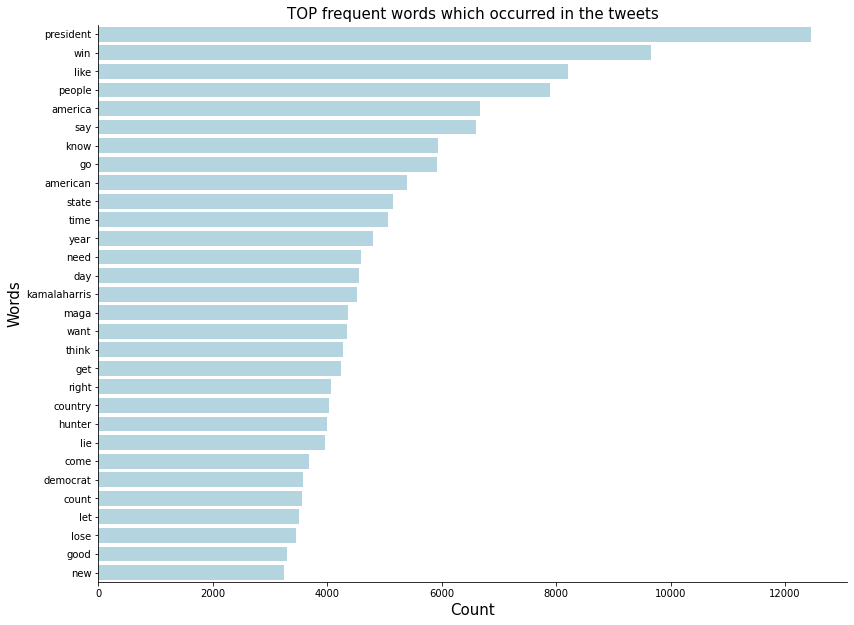

In [ ]:
#ploting top 20 words 
plt.figure(figsize=(40,20))
sns.catplot(y="word", x="frequency", kind="bar", color='lightblue', data=df_fdist20, height=8.27, aspect=11.7/8.27)
plt.title('TOP frequent words which occurred in the tweets', size = 15)
plt.xlabel('Count', size = 15)
plt.ylabel('Words', size = 15)
#plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))

## 2.2 Wordclouds

#### Creating the wordcloud for the all tweets to visuialize the discourse around the elections

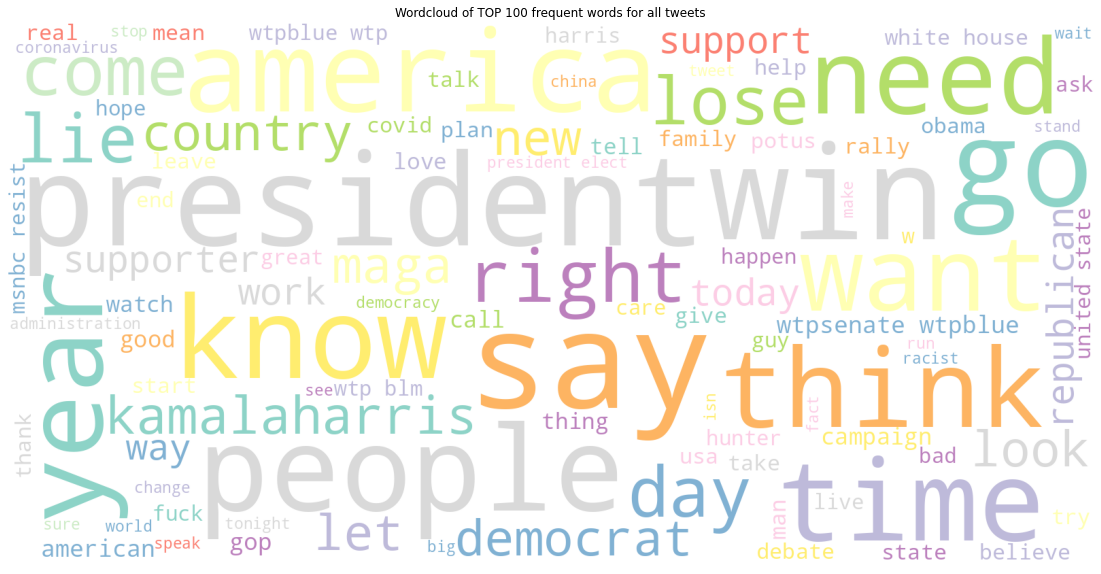

In [ ]:
# using list comprehension 
text_wordcloud= ' '.join(map(str, txt_tokens)) 

# Create and generate a word cloud image:
wordcloud = WordCloud(width=1600, height=800, max_font_size=200, max_words=100, colormap = 'Set3', background_color="white", collocations=True).generate(text_wordcloud)

# Display the generated image:
plt.figure(figsize=(20,10))
plt.imshow(wordcloud)
plt.title('Wordcloud of TOP 100 frequent words for all tweets')
plt.axis("off")
plt.show()

### 2.2.1 Wordclouds for Trump and Biden

In [ ]:
mylist = []
for string in biden_usa_df['lemmat_tweet']:
    mylist.append(string)
mylist

text_biden = str(mylist)

#tokenization
tokens_biden = word_tokenize(text_biden)
words_biden=[word.lower() for word in tokens_biden if word.isalpha()]
# using list comprehension 
words_biden= ' '.join(map(str, words_biden)) 

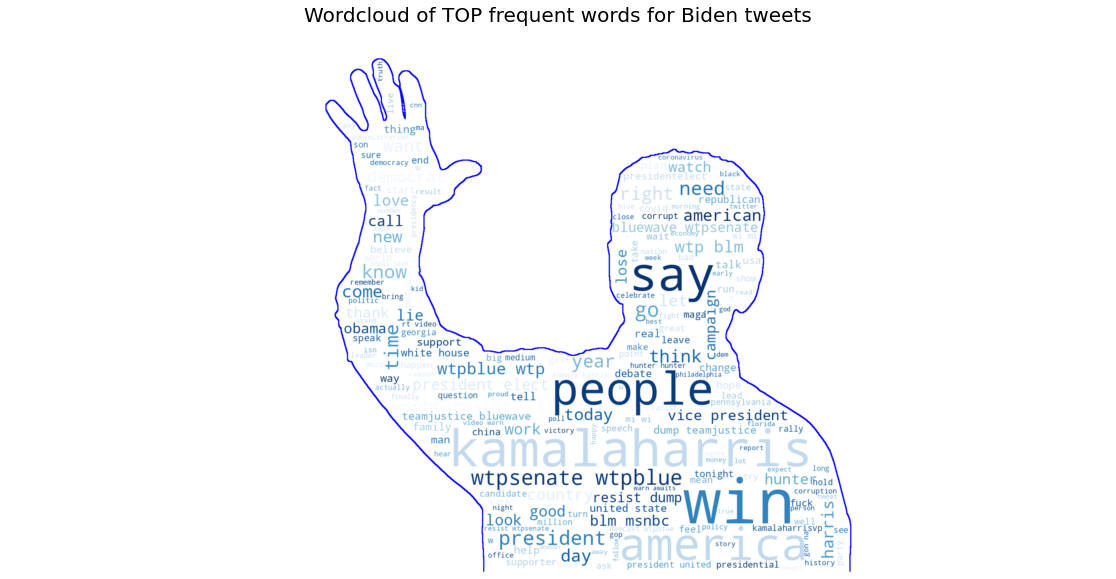

In [ ]:
# open the image and use np.array to transform the file to an array

cand_mask=np.array(Image.open('biden.png'))

# this line will take all values greater than 3 and make them 255 (white)
# if they are less than 3, they will be whatever value they are in the array
cand_mask=np.where(cand_mask > 3, 255, cand_mask)


#create and generate our wordcloud object
wordcloud = WordCloud(background_color='white',
                      contour_color='blue',
                      mask=cand_mask, colormap='Blues',
                      contour_width=4).generate(words_biden)


#plot
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Wordcloud of TOP frequent words for Biden tweets', fontsize = 20)
plt.axis('off')
plt.show()

In [ ]:
mylist = []
for string in trump_usa_df['lemmat_tweet']:
    mylist.append(string)
mylist

text_trump = str(mylist)

#tokenization
tokens_trump = word_tokenize(text_trump)
words_trump=[word.lower() for word in tokens_trump if word.isalpha()]
# using list comprehension 
words_trump= ' '.join(map(str, words_trump)) 

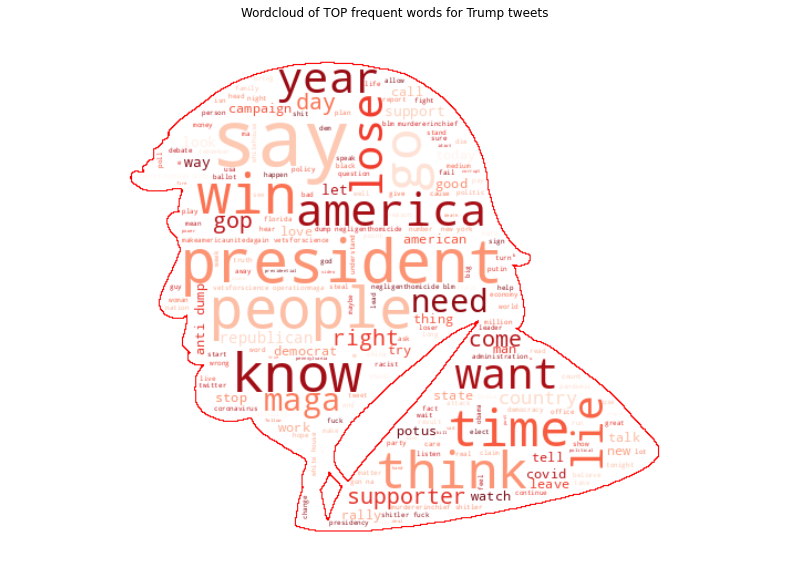

In [ ]:
# open the image and use np.array to transform the file to an array

cand_mask=np.array(Image.open('trump.png'))

# this line will take all values greater than 3 and make them 255 (white)
# if they are less than 3, they will be whatever value they are in the array
cand_mask=np.where(cand_mask > 3, 255, cand_mask)


#create and generate our wordcloud object
wordcloud = WordCloud(background_color='white',
                      contour_color='red',
                      mask=cand_mask, colormap='Reds',
                      contour_width=1).generate(words_trump)


#plot
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Wordcloud of TOP frequent words for Trump tweets')
plt.axis('off')
plt.show()

## 2.3 Bigrams

### Creating the list of the most occured bigrams in the tweets to explore the text deeper 

Text(0.5, 1.0, 'TOP 10 pair of words which occurred the texts')

<Figure size 1440x720 with 0 Axes>

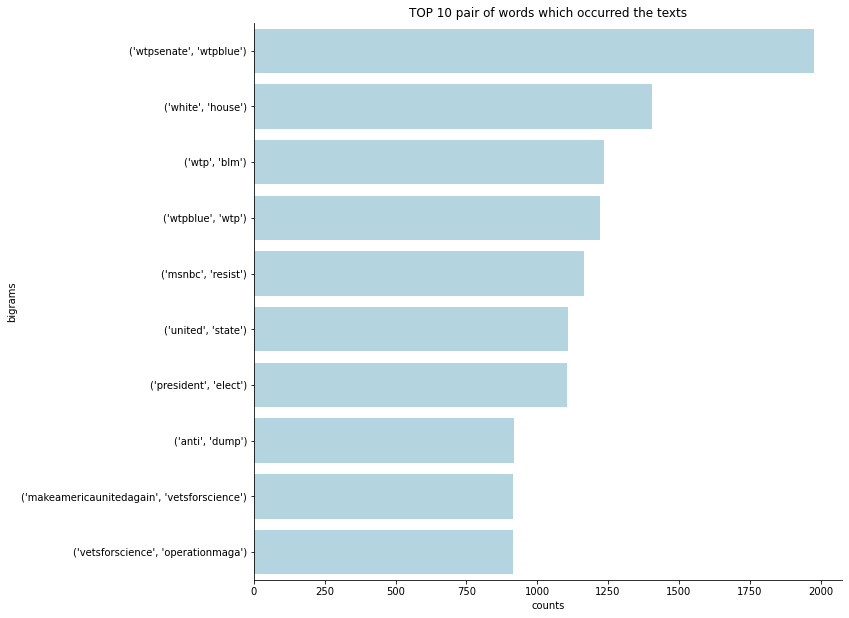

In [ ]:
#top 20 bigrams 
bigrams_series = (pd.Series(nltk.ngrams(txt_tokens, 2)).value_counts())[:10]
bigrams_top = pd.DataFrame(bigrams_series.sort_values(ascending=False))
bigrams_top = bigrams_top.reset_index().rename(columns={'index': 'bigrams', 0:'counts'})
bigrams_top
plt.figure(figsize=(20,10))
sns.catplot(x = 'counts' , y='bigrams', kind="bar", color='lightblue', data=bigrams_top, height=8.27, aspect=11.7/8.27)
plt.title('TOP 10 pair of words which occurred the texts')

## 2.4 Geographical analysis (Preparation)

We are interested in the public opinion of users that are tweeting about the election from the USA.

To better visualize our data we will use the geographic map of the United States in our visualizations. More specifically we will use a geojson file of the US states that we can then process with [Kepler](http://kepler.gl/). The .json file that we are using can be retrieved [here](https://eric.clst.org/tech/usgeojson/). 

In this part, we will load the .json file in a data frame and add a new feature 'src_max_tweets' to it. This feature indicates whether there are more tweets coming from a state with a #joebiden or #donaldtrump hashtag.

In [ ]:
trump_usa_df = twitter_usa_df[twitter_usa_df.initial_dataset=='trump']
biden_usa_df = twitter_usa_df[twitter_usa_df.initial_dataset=='biden']

In [ ]:
# Read in the US states geo file 
# geo_usa_df = pd.read_json('geo_usa.json')
# geo_usa_df.head()

# geo_df = pd.read_json('')
# geo_df.head()

# geo_usa_df.features
# GEO_ID = []
# STATE = []
# NAME = []
# CENSUSAREA = []
# geometry = []

# for row in geo_usa_df.features.iteritems():
#     GEO_ID.append(row[1]["properties"]["GEO_ID"])
#     STATE.append(row[1]["properties"]["STATE"])
#     NAME.append(row[1]["properties"]["NAME"])
#     CENSUSAREA.append(row[1]["properties"]["CENSUSAREA"])
#     geometry.append(row[1]["geometry"])

In [ ]:
# for row in geo_df.features.iteritems():
#     GEO_ID.append(row[1]["properties"]["GEO_ID"])
#     STATE.append(row[1]["properties"]["STATE"])
#     NAME.append(row[1]["properties"]["NAME"])
#     CENSUSAREA.append(row[1]["properties"]["CENSUSAREA"])
#     geometry.append(row[1]["geometry"])

In [ ]:
geo_usa_df['GEO_ID'] = GEO_ID
geo_usa_df['STATE'] = STATE
geo_usa_df['NAME'] = NAME
geo_usa_df['CENSUSAREA'] = CENSUSAREA
geo_usa_df['geometry'] = geometry

NameError: name 'GEO_ID' is not defined

In [ ]:
# Get the number of tweets per states and dataset (trump vs. biden)
trump_states_cnt = trump_df['State'].value_counts()
biden_states_cnt = biden_df['State'].value_counts()

In [ ]:
#Rename NAME feature to State
geo_usa_df = geo_usa_df.rename(columns={'NAME': 'State'})

In [ ]:
# Assign trump or biden depending on the max. amount of tweets per state
def assignVotes(state, cand):
    try:
        return trump_states_cnt[state] if (cand == 'trump') else biden_states_cnt[state]
    except:
        return float('NaN')

geo_usa_df['trump_states_cnt'] = geo_usa_df['State'].apply(lambda x: assignVotes(x,'trump'))
geo_usa_df['biden_states_cnt'] = geo_usa_df['State'].apply(lambda x: assignVotes(x,'biden'))

geo_usa_df['src_max_tweets'] = geo_usa_df['trump_states_cnt'] - geo_usa_df['biden_states_cnt']
geo_usa_df['src_max_tweets'] = geo_usa_df['src_max_tweets'].apply(lambda x: 'trump' if x > 0 else 'biden')

In [ ]:
geo_usa_df = geo_usa_df.drop(columns =['STATE','CENSUSAREA','trump_states_cnt','biden_states_cnt'])

In [ ]:
geo_usa_df.head()

,type,features,GEO_ID,State,geometry,src_max_tweets
0,FeatureCollection,"{'type': 'Feature', 'properties': {'GEO_ID': '0400000US23', 'STATE': '23', 'NAME': 'Maine', 'LSAD': '', 'CENSUSAREA': 30842.923}, 'geometry': {'type': 'MultiPolygon', 'coordinates': [[[[-67.619761, 44.519754], [-67.61541, 44.521973], [-67.587738, 44.516196], [-67.582113, 44.513459], [-67.589259,...",0400000US23,Maine,"{'type': 'MultiPolygon', 'coordinates': [[[[-67.619761, 44.519754], [-67.61541, 44.521973], [-67.587738, 44.516196], [-67.582113, 44.513459], [-67.589259, 44.50084], [-67.590627, 44.49415], [-67.580288, 44.488068], [-67.562651, 44.472104], [-67.569189, 44.455531], [-67.571774, 44.453403], [-67.5...",trump
1,FeatureCollection,"{'type': 'Feature', 'properties': {'GEO_ID': '0400000US25', 'STATE': '25', 'NAME': 'Massachusetts', 'LSAD': '', 'CENSUSAREA': 7800.058}, 'geometry': {'type': 'MultiPolygon', 'coordinates': [[[[-70.832044, 41.606504], [-70.823735, 41.598569], [-70.820918, 41.587673], [-70.82191, 41.582841], [-70....",0400000US25,Massachusetts,"{'type': 'MultiPolygon', 'coordinates': [[[[-70.832044, 41.606504], [-70.823735, 41.598569], [-70.820918, 41.587673], [-70.82191, 41.582841], [-70.830087, 41.585385], [-70.838452, 41.59646], [-70.832044, 41.606504]]], [[[-70.59628, 41.471905], [-70.57485, 41.468259], [-70.567356, 41.471208], [-7...",biden
2,FeatureCollection,"{'type': 'Feature', 'properties': {'GEO_ID': '0400000US26', 'STATE': '26', 'NAME': 'Michigan', 'LSAD': '', 'CENSUSAREA': 56538.901}, 'geometry': {'type': 'MultiPolygon', 'coordinates': [[[[-88.684434, 48.115785], [-88.675628, 48.120444], [-88.676395, 48.124876], [-88.674192, 48.127165], [-88.656...",0400000US26,Michigan,"{'type': 'MultiPolygon', 'coordinates': [[[[-88.684434, 48.115785], [-88.675628, 48.120444], [-88.676395, 48.124876], [-88.674192, 48.127165], [-88.656915, 48.139225], [-88.614026, 48.154797], [-88.578413, 48.16237], [-88.547033, 48.174891], [-88.524753, 48.165291], [-88.501088, 48.168181], [-88...",trump
3,FeatureCollection,"{'type': 'Feature', 'properties': {'GEO_ID': '0400000US30', 'STATE': '30', 'NAME': 'Montana', 'LSAD': '', 'CENSUSAREA': 145545.801}, 'geometry': {'type': 'Polygon', 'coordinates': [[[-104.057698, 44.997431], [-104.250145, 44.99822], [-104.470117, 44.998453], [-104.470422, 44.998453], [-104.66388...",0400000US30,Montana,"{'type': 'Polygon', 'coordinates': [[[-104.057698, 44.997431], [-104.250145, 44.99822], [-104.470117, 44.998453], [-104.470422, 44.998453], [-104.663882, 44.998869], [-104.665171, 44.998618], [-104.72637, 44.999518], [-104.759855, 44.999066], [-104.765063, 44.999183], [-105.01824, 45.000437], [-...",biden
4,FeatureCollection,"{'type': 'Feature', 'properties': {'GEO_ID': '0400000US32', 'STATE': '32', 'NAME': 'Nevada', 'LSAD': '', 'CENSUSAREA': 109781.18}, 'geometry': {'type': 'Polygon', 'coordinates': [[[-114.0506, 37.000396], [-114.049995, 36.957769], [-114.050619, 36.843128], [-114.050562, 36.656259], [-114.050167, ...",0400000US32,Nevada,"{'type': 'Polygon', 'coordinates': [[[-114.0506, 37.000396], [-114.049995, 36.957769], [-114.050619, 36.843128], [-114.050562, 36.656259], [-114.050167, 36.624978], [-114.04966, 36.621113], [-114.048476, 36.49998], [-114.046488, 36.473449], [-114.045829, 36.442973], [-114.045806, 36.391071], [-1...",biden


In [ ]:
# Read in the lat and long of states captials 
geo_us_capitals_df = pd.read_csv('us-state-capitals.csv')

#Rename NAME feature to State
geo_us_capitals_df = geo_us_capitals_df.rename(columns={'origin': 'State'})
geo_us_capitals_df.head()

,State,latitude,longitude
0,Alabama,32.361538,-86.279118
1,Alaska,58.301935,-134.419740
2,Arizona,33.448143,-112.096962
3,Arkansas,34.746613,-92.288986
4,California,38.576668,-121.493629


In [ ]:
geo_usa_df = pd.merge(geo_usa_df, geo_us_capitals_df, on='State')

In [ ]:
geo_usa_df.to_json('geo_usa_df.json',orient='records')

### Map of US States
- blue indicates that more tweets with the hashtag #joebiden are coming from this state than #donaldtrump
- red indicates that more tweets with the hashtag #donaldtrump are coming from this state than #joebiden

![](us_states_biden_trump.png) 


## 2.5 Date and time analysis

### Minimum and maximum dates in dataframe


In [ ]:
print(f" Data Available since {twitter_usa_df.created_at.min()}")
print(f" Data Available upto {twitter_usa_df.created_at.max()}")

 Data Available since 2020-10-15 00:00:02
 Data Available upto 2020-11-08 23:58:51


### Number of tweets according to Dates

In [ ]:
twitter_usa_df['created_at'] =  pd.to_datetime(twitter_usa_df['created_at'])
cnt_srs = twitter_usa_df['created_at'].dt.date.value_counts()
cnt_srs = cnt_srs.sort_index()

/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


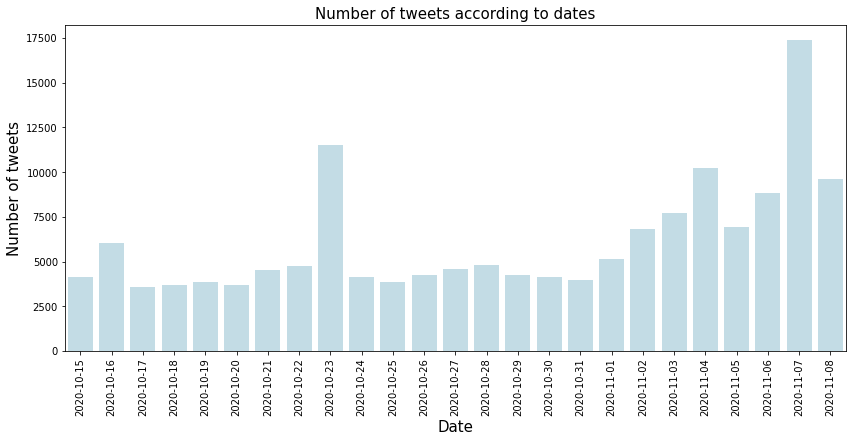

In [ ]:
plt.figure(figsize=(14,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color='lightblue')
plt.xticks(rotation='vertical')
plt.xlabel('Date', fontsize=15)
plt.ylabel('Number of tweets', fontsize=15)
plt.title("Number of tweets according to dates", size = 15)
plt.show()

## 2.6 Tweets popularity analysis

### Most retweeted tweet


In [ ]:
tweet_retweet_max = twitter_usa_df.loc[twitter_usa_df['Retweets'].idxmax()]

In [ ]:
tweet_retweet_max

created_at                                       2020-11-06 16:31:06
tweet              America Assembled!🇺🇸🎉\n\n@JoeBiden @KamalaHarr...
Likes                                                          74528
Retweets                                                       20615
source                                            Twitter for iPhone
Followers                                                       8080
user_location                                           Brooklyn, NY
lat                                                          40.6501
long                                                        -73.9496
city                                                        New York
country                                                United States
continent                                              North America
State                                                       New York
state_code                                                        NY
initial_dataset                   

In [ ]:
print(f" The tweet '{tweet_retweet_max.tweet}' was retweeted the most with {tweet_retweet_max.Retweets} number of retweets.")


 The tweet 'America Assembled!🇺🇸🎉

@JoeBiden @KamalaHarris @BarackObama 
@ChrisEvans  @MarkRuffalo @RobertDowneyJr @brielarson @AOC @staceyabrams @michaelb4jordan @Russo_Brothers 
#Election2020 #ElectionResults2020 #joebiden #DonaldTrump #BidenHarris2020 #avengers #endgame https://t.co/cDl1VsFbOo' was retweeted the most with 20615.0 number of retweets.


## 2.7 "Vocal minority" and "silent majority" effect

Mustafaraj et al. 2011 \[1] showed evidence of the existance on social media of a minority of users which are very vocal, while there is a majority of users which hardly produce content.

We explore this phenomenon in our dataset by looking at the distribution of the number of tweets per user.  
The frequency distribution we obtain confirms that there are a small number of users producing a large portion of the tweets for both candidates (the trend is stronger for Biden).  
This indicates that:    
- drawing conclusions about which candidate is preferred based on the number of tweets would be influenced strongly by this small number of very active users.  

In the section dedicated to 'predicting' election results from Tweets, we will see how we can enforce a policy of 'one vote per person' when analysing tweets.  

**\[1]** Eni Mustafaraj, Samantha Finn, Carolyn Whitlock, and Panagiotis Takis Metaxas. **Vocal minority versus silent majority: Discovering the opionions
of the long tail.** In SocialCom/PASSAT, pages 103–110, 2011.


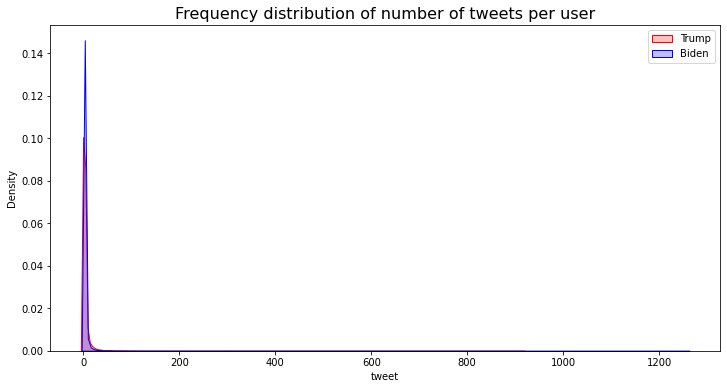

In [ ]:
fig, ax=plt.subplots(1,1, figsize=(12,6))

ax.set_title('Frequency distribution of number of tweets per user', fontsize = 16)
sns.kdeplot(trump_usa_df.groupby(['user_id'])['tweet'].count(), shade=True, color='r', label='Trump', ax = ax)
sns.kdeplot(biden_usa_df.groupby(['user_id'])['tweet'].count(), shade=True, color='b', label='Biden', ax = ax)
labels= ["Trump", "Biden"]
ax.legend(labels)
#ax.set_ylim(0, .005)
plt.show()

# 3.  Sentiment Analysis

Sentiment analysis means computing in some way the overall valence of the text. Valence usually means weather a text is negative, neutral or positive.  
Different libraries / algorithms assess text valence in different ways, but this would be the gist of the sentiment analysis.

We identified two popular approaches in performing sentiment analysis:
- **Rule-based** sentiment analysis.  
    This is the simple approach, does not employ machine learning and needs minimal preparation of data in advance.
- **Embedding based** models.  
    This uses words embeddings, an approach where words are represented as vectors of numbers in an n-dimensional space.  

We are going to use three popular libraries in this Notebook:
- **TextBlob**
- **VADER (included in the Natural Language Toolkit - nltk)**
- **Flair**


First, we clean our data.
For lemmatization, different libraries give slightly different results.
For an extensive comparison, see this article: https://www.machinelearningplus.com/nlp/lemmatization-examples-python/

In [ ]:
'''
first we will perform 'cleaning' of the tweets: remove unnecessary words (stopwords and two letter words), punctuation etc 
'''
import nltk
from nltk.corpus import wordnet

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

# Import word_tokenize and stopwords from nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Install spaCy (run in terminal/prompt)
import sys
!{sys.executable} -m pip install spacy

# Download spaCy's  'en' Model
!{sys.executable} -m spacy download en

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def clean_text_2(tweet, lemmatize = 'nltk'):
    '''
    input:
      - tweet = a string representing the text you need to clean
      - lemmatize = {spacy, nltk} 
      two lemmatization methods
      with our dataset, we got the best results with nltk
      but Spacy also did a good job, hence you might 
      try both and compare results for your data
    out: 
      - the cleaned text, tokenized (a list of string words)
    '''

    # lowercase
    tweet = tweet.lower()
    
    # Remove links
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)
    
    # Remove mentions and the hashtag character
    tweet = re.sub(r'\@\w+|\#','', tweet)
    
    # remove stopwords with Gensim
    tweet=remove_stopwords(tweet)

    if (lemmatize == 'spacy'):
        # Initialize spacy 'en' model, keeping only tagger component needed for lemmatization
        nlp = spacy.load('en', disable=['parser', 'ner'])
        doc = nlp(tweet)
        tokenized = [token.lemma_ for token in doc if token.lemma_ != '-PRON-']
    elif (lemmatize == 'nltk'): 
        '''
        lemmatization works best when WordNetLemmatizer receives both the text and the part of speech of each word
        the code below assigns POS (part of speech) tag on a per word basis (it does not infer POS from contenxt / sentence), which might not be optimal
        '''
        lemmatizer = WordNetLemmatizer()
        tokenized = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(tweet)]
    
    # Remove the stop words with NLTK
    # to make sure no unimportant words are left
    tokenized = [token for token in tokenized if token not in stopwords.words("english")] 

    # Remove non-alphabetic characters and keep the words contains three or more letters
    tokenized = [token for token in tokenized if token.isalpha() and len(token)>2]

    #non_tokenized = ' '.join([w for w in tokenized])
        
    return tokenized

def combine_tokens(tokenized): 
  
    non_tokenized = ' '.join([w for w in tokenized])
  
    return non_tokenized


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
2021-05-28 09:49:10.608275: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-05-28 09:49:10.608335: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline pa

Perform a quick test to see which lemmatizer performs best on our data

In [ ]:
'''
temp = twitter_usa_df.head(20).copy()

import time
start =  time.time()

temp['tokenized_tweet_spacy'] = temp['tweet'].apply(lambda x: clean_text_2(x, 'spacy'))
temp['clean_tweet_spacy'] = temp['tokenized_tweet_spacy'].apply(lambda x: combine_tokens(x))

temp['tokenized_tweet_nltk'] = temp['tweet'].apply(lambda x: clean_text_2(x, 'nltk'))
temp['clean_tweet_nltk'] = temp['tokenized_tweet_nltk'].apply(lambda x: combine_tokens(x))

stop = time.time()
print('Cleaning tweets takes this many minutes: ', round((stop-start)/60, 3))
'''

"\ntemp = twitter_usa_df.head(20).copy()\n\nimport time\nstart =  time.time()\n\ntemp['tokenized_tweet_spacy'] = temp['tweet'].apply(lambda x: clean_text_2(x, 'spacy'))\ntemp['clean_tweet_spacy'] = temp['tokenized_tweet_spacy'].apply(lambda x: combine_tokens(x))\n\ntemp['tokenized_tweet_nltk'] = temp['tweet'].apply(lambda x: clean_text_2(x, 'nltk'))\ntemp['clean_tweet_nltk'] = temp['tokenized_tweet_nltk'].apply(lambda x: combine_tokens(x))\n\nstop = time.time()\nprint('Cleaning tweets takes this many minutes: ', round((stop-start)/60, 3))\n"

In [ ]:
#uncomment the line below if you want to run your own test
#to keep the output short, we commented it out after running the test 
#and we present the results in a stylized screeshot 
#temp[['tweet', 'clean_tweet_spacy', 'clean_tweet_nltk']]

Each lemmatizer seems to have its hits and misses. Since the difference is not that big, we decided after visual inspection to continue with nltk



![Picture title](image-20210120-161302.png)

Cleaning our tweets

In [ ]:
import time
start =  time.time()
twitter_usa_df['tokenized_tweet_nltk'] = twitter_usa_df['tweet'].apply(lambda x: clean_text_2(x, 'nltk'))
twitter_usa_df['clean_tweet_nltk'] = twitter_usa_df['tokenized_tweet_nltk'].apply(lambda x: combine_tokens(x))
stop = time.time()
print('Cleaning all tweets takes this many minutes: ', round((stop-start)/60, 3))

trump_usa_df = twitter_usa_df[twitter_usa_df.initial_dataset=='trump']
biden_usa_df = twitter_usa_df[twitter_usa_df.initial_dataset=='biden']

Cleaning all tweets takes this many minutes:  17.678


## 3.1 Sentiment analysis using TextBlob

According to [TextBlob's official website](https://textblob.readthedocs.io/en/dev/), TextBlob "provides a simple API for diving into common natural language processing (NLP) tasks such as part-of-speech tagging, noun phrase extraction, sentiment analysis, classification, translation, and more."

TextBlob library will output something like this for each snippet of text that it analyzes:  
_Sentiment(polarity=-0.125, subjectivity=0.5916666666666667)_

That is, TextBlob will output:
- a measure of polarity, which can have values in the interval \[-1, 1\]
- an estimation of subjectivity, ranging is \[0.0, 1.0\] where 0.0 is very objective (dealing with facts) and 1.0 is very subjective (opinions). 

Interpreting the results:  
- TextBlob documentation does not give precise guidelines for interpreting the numberic output ([see TextBlob ReadTheDocs section for Sentiment analysis here](https://textblob.readthedocs.io/en/dev/quickstart.html#sentiment-analysis))
- We will adopt the approach we encountered in [this KDNuggets post](https://www.kdnuggets.com/2018/08/emotion-sentiment-analysis-practitioners-guide-nlp-5.html):  
  - we will label <0 values as 'negative' 
  - 0 values as 'neutral' 
  - and \>0 values as 'positive' 

Function for labelling tweets based on classification criteria described above.

In [ ]:
# Helper Function to assign Label for Sentiment Analysis with TextBlob
def create_sentiment_labels(df, feature,value):
    '''
    in: 
        dataframe 
        value on which to classify
        feature - column name of the feature that receives the label
    out: 
        does not return a value
        modifies the dataframe received as parameter
    '''

    df.loc[df[value] > 0,feature] = 'positive'
    df.loc[df[value] == 0,feature] = 'neutral'
    df.loc[df[value] < 0,feature] = 'negative'

In [ ]:
# Polarity and subjectivity
def sentiment_analysis(dataframe):
    dataframe['blob_polarity'] = dataframe['clean_tweet_nltk'].apply(lambda x: TextBlob(x).sentiment.polarity)
    dataframe['blob_subjectivity'] = dataframe['clean_tweet_nltk'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

    create_sentiment_labels(dataframe, 'blob_sentiment','blob_polarity')
    
    return dataframe[['clean_tweet_nltk','blob_polarity','blob_subjectivity','blob_sentiment']].head()   

In [ ]:
import time
start =  time.time()

sentiment_analysis(twitter_usa_df)

stop = time.time()
print('Sentiment analysis with TextBlob took: ', round((stop-start)/60, 3))

#update the divided dataset
trump_usa_df = twitter_usa_df[twitter_usa_df.initial_dataset=='trump']
biden_usa_df = twitter_usa_df[twitter_usa_df.initial_dataset=='biden']

Sentiment analysis with TextBlob took:  1.381


### 3.1.1 Different ways to look at the same data.  

#### Option a

In the next plot, we will compute an average polarity per candidate as follows:  
- we simply average the polarity feature computed by TextBlob across all tweets per candidate. 

Issues with this approach:  
- imagine we have 1 user who tweeted 99 times, each having polarity -1 (a candidate opposer). And 1 user who tweeted once with polarity 1 (a candidate supporter). If we average across all tweets, we obtain **-0.98**.  
What can we infer from this result ? 
- inferring support / opposing for the candidate would be wrong, since in our sample we actually have one opposant and 1 supporter.
- we can only infer the trivial: that the result is just the average sentiment across all tweets.

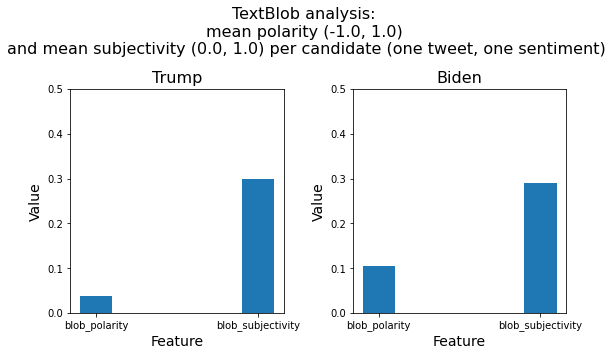

In [ ]:
#update the divided dataset
trump_usa_df = twitter_usa_df[twitter_usa_df.initial_dataset=='trump']
biden_usa_df = twitter_usa_df[twitter_usa_df.initial_dataset=='biden']

fig, axes = plt.subplots(1, 2, figsize=(8,5))

fig.suptitle('TextBlob analysis: \nmean polarity (-1.0, 1.0) \nand mean subjectivity (0.0, 1.0) per candidate (one tweet, one sentiment)', fontsize=16)

features = ['blob_polarity', 'blob_subjectivity']
values = [trump_usa_df.groupby(['user_id'])['blob_polarity'].mean().mean(), trump_usa_df.groupby(['user_id'])['blob_subjectivity'].mean().mean()]
axes[0].bar(features,values, width=0.2)
axes[0].set_ylim(0, .5)
axes[0].set_title('Trump', fontsize = 16)
axes[0].set_xlabel('Feature', fontsize = 14)
axes[0].set_ylabel('Value', fontsize = 14)

values = [biden_usa_df.groupby(['user_id'])['blob_polarity'].mean().mean(), biden_usa_df.groupby(['user_id'])['blob_subjectivity'].mean().mean()]
axes[1].bar(features,values, width=0.2)
axes[1].set_ylim(0, .5)
axes[1].set_title('Biden', fontsize = 16)
axes[1].set_xlabel('Feature', fontsize = 14)
axes[1].set_ylabel('Value', fontsize = 14)

fig.tight_layout()
plt.show()

trump_usa_pol_tweet =trump_usa_df['blob_polarity'].mean()
trump_usa_subj_tweet = trump_usa_df['blob_subjectivity'].mean()
biden_usa_pol_tweet = biden_usa_df['blob_polarity'].mean()
biden_usa_subj_tweet = biden_usa_df['blob_subjectivity'].mean()

#### Option b  

Another option is to:
- first average sentiment expressed through tweets per user id -> we will have one averge expressed sentiment per user per candidate
- then avergae across the whole population for each candidate

Number of users who tweeted about Trump:  21049
Number of users who tweeted about Biden:  28482


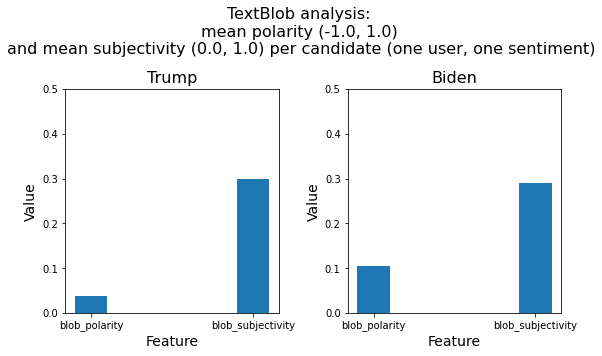

In [ ]:
#how many users tweeted about trump
print('Number of users who tweeted about Trump: ', trump_usa_df.user_id.nunique())
print('Number of users who tweeted about Biden: ', biden_usa_df.user_id.nunique())

# the below gives us a mean per user
# trump_usa_df[['user_id', 'Polarity']].groupby(['user_id'])['Polarity'].mean()

fig, axes = plt.subplots(1, 2, figsize=(8, 5))

fig.suptitle('TextBlob analysis: \nmean polarity (-1.0, 1.0) \nand mean subjectivity (0.0, 1.0) per candidate (one user, one sentiment)', fontsize=16)

features = ['blob_polarity', 'blob_subjectivity']
values = [trump_usa_df.groupby(['user_id'])['blob_polarity'].mean().mean(), trump_usa_df.groupby(['user_id'])['blob_subjectivity'].mean().mean()]
axes[0].bar(features,values, width=0.2,)
axes[0].set_ylim(0, .5)
axes[0].set_title('Trump', fontsize = 16)
axes[0].set_xlabel('Feature', fontsize = 14)
axes[0].set_ylabel('Value', fontsize = 14)

values = [biden_usa_df.groupby(['user_id'])['blob_polarity'].mean().mean(), biden_usa_df.groupby(['user_id'])['blob_subjectivity'].mean().mean()]
axes[1].bar(features,values, width=0.2,)
axes[1].set_ylim(0, .5)
axes[1].set_title('Biden', fontsize = 16)
axes[1].set_xlabel('Feature', fontsize = 14)
axes[1].set_ylabel('Value', fontsize = 14)

fig.tight_layout()
plt.show()

trump_usa_pol_user = trump_usa_df.groupby(['user_id'])['blob_polarity'].mean().mean()
trump_usa_subj_user = trump_usa_df.groupby(['user_id'])['blob_subjectivity'].mean().mean()
biden_usa_pol_user = biden_usa_df.groupby(['user_id'])['blob_polarity'].mean().mean()
biden_usa_subj_user = biden_usa_df.groupby(['user_id'])['blob_subjectivity'].mean().mean()

### Let's see how our results are influenced by choosing either of the two options mentioned above


/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator


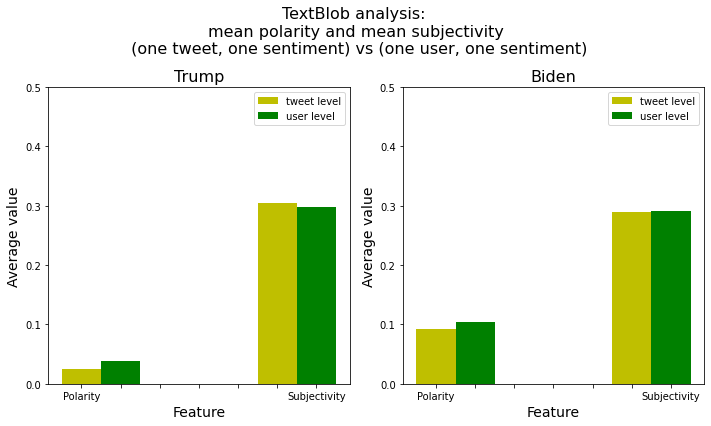

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10,6))

fig.suptitle('TextBlob analysis: \nmean polarity and mean subjectivity\n (one tweet, one sentiment) vs (one user, one sentiment)', fontsize=16)

#features = ['Polarity', 'Subjectivity']
features = np.array([1, 2])
values_tweet = [ trump_usa_pol_tweet, trump_usa_subj_tweet]
values_user = [ trump_usa_pol_user, trump_usa_subj_user]

#values = [[trump_usa_pol_tweet, trump_usa_subj_tweet], 
#[trump_usa_pol_user, trump_usa_subj_user]]

axes[0].bar(features-0.2, values_tweet, width=0.2, align = 'center', color = 'y')
axes[0].bar(features, values_user, width=0.2, align = 'center', color = 'g')
#axes[0].bar(features,values)
axes[0].set_ylim(0, .5)
axes[0].set_title('Trump', fontsize = 16)
axes[0].set_xlabel('Feature', fontsize = 14)
axes[0].set_ylabel('Average value', fontsize = 14)
axes[0].set_xticklabels(['', 'Polarity', '', '', '', '', '', 'Subjectivity'])
labels= ["tweet level", "user level"]
axes[0].legend(labels)

values_tweet = [ biden_usa_pol_tweet, biden_usa_subj_tweet]
values_user = [ biden_usa_pol_user, biden_usa_subj_user]
axes[1].bar(features-0.2,values_tweet, width=0.2, align = 'center', color = 'y')
axes[1].bar(features,values_user, width=0.2, align = 'center', color = 'g')
axes[1].set_ylim(0, .5)
axes[1].set_title('Biden', fontsize = 16)
axes[1].set_xlabel('Feature', fontsize = 14)
axes[1].set_ylabel('Average value', fontsize = 14)
axes[1].set_xticklabels(['', 'Polarity', '', '', '', '', '', 'Subjectivity'])

labels= ["tweet level", "user level"]
axes[1].legend(labels)

fig.tight_layout()
plt.show()

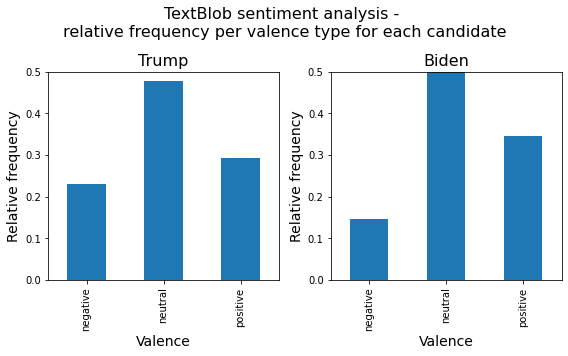

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(8,5))

fig.suptitle('TextBlob sentiment analysis - \nrelative frequency per valence type for each candidate', fontsize=16)
(trump_usa_df['blob_sentiment'].sort_values().value_counts()/trump_usa_df['blob_sentiment'].shape[0])[['negative', 'neutral', 'positive']].plot(kind='bar', ax = axes[0])

axes[0].set_ylim(0, .5)
axes[0].set_title('Trump', fontsize = 16)
axes[0].set_xlabel('Valence', fontsize = 14)
axes[0].set_ylabel('Relative frequency', fontsize = 14)

(biden_usa_df['blob_sentiment'].sort_values().value_counts()/biden_usa_df['blob_sentiment'].shape[0])[['negative', 'neutral', 'positive']].plot(kind='bar', ax = axes[1])

axes[1].set_ylim(0, .5)
axes[1].set_title('Biden', fontsize = 16)
axes[1].set_xlabel('Valence', fontsize = 14)
axes[1].set_ylabel('Relative frequency', fontsize = 14)

fig.tight_layout()
plt.show()


## 3.2 Sentiment analysis using VADER

  
VADER (Valence Aware Dictionary for Sentiment Reasoning) was developed in 2014.   
You can check [Vader's official github](https://github.com/cjhutto/vaderSentiment) for details of how the tool was designed and how to use it. 

According to [VADER's github](https://github.com/cjhutto/vaderSentiment), VADER is "specifically attuned to sentiments expressed in social media".  
_"Empirically validated by multiple independent human judges, VADER incorporates a "gold-standard" sentiment lexicon that is especially attuned to microblog-like contexts."_

Vader is a pre-trained model. If you want to read about the model in detail, the official website recommends this article below:  
Hutto, C.J. & Gilbert, E.E. (2014). VADER: A Parsimonious Rule-based Model for Sentiment Analysis of Social Media Text. Eighth International Conference on Weblogs and Social Media (ICWSM-14). Ann Arbor, MI, June 2014.

Vader **outputs** something like this:   
_{'neg': 0.0, 'neu': 0.436, 'pos': 0.564, 'compound': 0.3802}_

**Negative**, **neutral** and **positive** are scores between 0 and 1.  
The **compound** value reflects the overall sentiment of the text. It's computed based on the values of negative, neutral and positive. It ranges from -1 (maximum negativity) to 1 (maximum positivity). 

The is no standard way to interpret compound. 
One can decide that whatever is larger than 0 is positive and lower is negative, while 0 means neutral.    
But we can also decide to look only at more extreme values, like above or below +/- 0.8, for example.   
It really depends on the kid of data we have.

In [ ]:
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
def sentiment_analysis_vader(df, clean = True):
    if clean:
        target_col = 'clean_tweet_nltk'
        prefix = 'vader_clean_'
    else:
        target_col = 'tweet'
        prefix = 'vader_'
    
    scores_col = prefix+'scores'
    
    #let's make it vader_sentiment, so that it has the same naming convention as TextBlob and Flair sentiment score
    #compound_col = prefix+'compound'
    compound_col = prefix+'polarity'
    
    #comp_score_col = prefix+'comp_score'
    comp_score_col = prefix+'sentiment' 
    
    df[scores_col] = df[target_col].apply(lambda tweet: sid.polarity_scores(tweet))
    df[compound_col] = df[scores_col].apply(lambda d: d['compound'])
    create_sentiment_labels(df,comp_score_col,compound_col)


In [ ]:
sentiment_analysis_vader(twitter_usa_df)
sentiment_analysis_vader(twitter_usa_df, clean = False)

#update the divided dataset
trump_usa_df = twitter_usa_df[twitter_usa_df.initial_dataset=='trump']
biden_usa_df = twitter_usa_df[twitter_usa_df.initial_dataset=='biden']

'''
sentiment_analysis_vader(trump_usa_df)
sentiment_analysis_vader(biden_usa_df)

sentiment_analysis_vader(trump_usa_df, clean = False)
sentiment_analysis_vader(biden_usa_df, clean = False)
'''

'\nsentiment_analysis_vader(trump_usa_df)\nsentiment_analysis_vader(biden_usa_df)\n\nsentiment_analysis_vader(trump_usa_df, clean = False)\nsentiment_analysis_vader(biden_usa_df, clean = False)\n'

In [ ]:
#pd.options.display.max_colwidth = 50
#trump_usa_df.head()

Does it matter if we clean the tweets before feeding them to Vader ? Does Vader itself perform a good enough cleaning ?  
We answer this question by classifying tweets into positive / neutral / negative using both approaches and then looking at the accuracy_score for the labels obtained through the two methods.

In [ ]:
from sklearn.metrics import accuracy_score
print(f"Accuracy score for our cleaning vs vader tweet cleaning for Trump: {accuracy_score(trump_usa_df['vader_sentiment'],trump_usa_df['vader_clean_sentiment']):.4}")
print(f"Accuracy score for our cleaning vs vader tweet cleaning for Biden: {accuracy_score(biden_usa_df['vader_sentiment'],biden_usa_df['vader_clean_sentiment']):.4}")

Accuracy score for our cleaning vs vader tweet cleaning for Trump: 0.8425
Accuracy score for our cleaning vs vader tweet cleaning for Biden: 0.8819


It looks like there is 84% consensus for Trump and 88% consensus for Biden for sentiment per tweet when VADER is fed the raw data versus the cleaned data.  
So that means the decision to feed raw or cleaned data should be given some thought.  
Since we don't have labelled data, the only way to decide which method is best is by visual inspection.  

In [ ]:
#Uncomment the code below if you want to visualize some tweets yourself
#We decided based on this to feed the raw tweet to VADER and let it run the cleaning itself

'''
#Some tweets arel long. This setting makes sure Python does not truncate the output. Default value is 50.
pd.options.display.max_colwidth = 300
print(trump_usa_df[['tweet', 'clean_tweet_nltk', 'vader_sentiment', 'vader_clean_sentiment']].head(20))
'''

"\n#Some tweets arel long. This setting makes sure Python does not truncate the output. Default value is 50.\npd.options.display.max_colwidth = 300\nprint(trump_usa_df[['tweet', 'clean_tweet_nltk', 'vader_sentiment', 'vader_clean_sentiment']].head(20))\n"

In [ ]:
#trump_usa_df.drop(columns = ['vader_clean_scores', 'vader_clean_sentiment', 'vader_clean_comp_score'], axis = 1, inplace = True)

Let's have a look at number of tweets per valence for both candidates and see if we spot anything interesting. 

In [ ]:
def get_valence_relative_freq(df):
    #grouped = df.sort_values('comp_score').groupby(['comp_score'], sort=False)
    grouped = df.sort_values('vader_sentiment').groupby(['vader_sentiment'], sort=False)
    valence = grouped['vader_sentiment'].value_counts(normalize=False, sort=False)
    valence = valence.droplevel(0)
    valence = valence / valence.sum()
    return valence

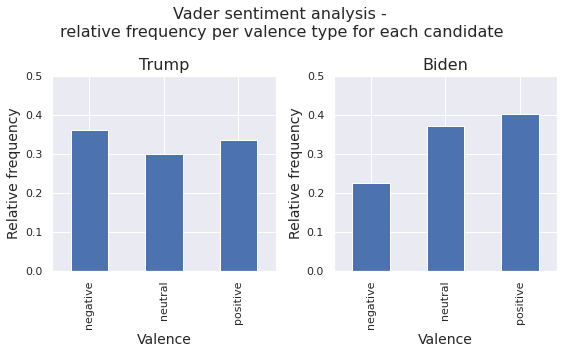

In [ ]:
import seaborn as sns
sns.set_theme(style="darkgrid")

trump_tmp = get_valence_relative_freq(trump_usa_df)
biden_tmp = get_valence_relative_freq(biden_usa_df)

#plt.figure(figsize=(8,6))
fig, axes = plt.subplots(1, 2, figsize=(8,5))
fig.suptitle('Vader sentiment analysis - \nrelative frequency per valence type for each candidate', fontsize=16)
#fig.tight_layout()

#sns.barplot(trump_tmp.index, trump_tmp.values, ax=axes[0])
(trump_tmp).plot(kind='bar', ax = axes[0])
axes[0].set_title('Trump', fontsize = 16)
axes[0].set_xlabel('Valence', fontsize = 14)
axes[0].set_ylabel('Relative frequency', fontsize = 14)
axes[0].set_ylim(0, .5)

#ax2 = sns.countplot(x="comp_score", data=biden_tmp)
#sns.barplot(biden_tmp.index, biden_tmp.values,  ax=axes[1])
(biden_tmp).plot(kind='bar', ax = axes[1])
axes[1].set_title('Biden', fontsize = 16)
axes[1].set_xlabel('Valence', fontsize = 14)
axes[1].set_ylabel('Relative frequency', fontsize = 14)
axes[1].set_ylim(0, .5)

plt.tight_layout()
plt.show()

### Some observations we can make based on the two plots above:
- within-candidates: Trump has a ratio of 1:1 for positive to negative tweets, while for Biden, it's almost 2:1
- between-candidates: 
    - higher % of positive tweets for Biden
    - higher % of negative tweets for Trump

## Average sentiment score per candidate

-0.02482871745395926
0.1098553084037905


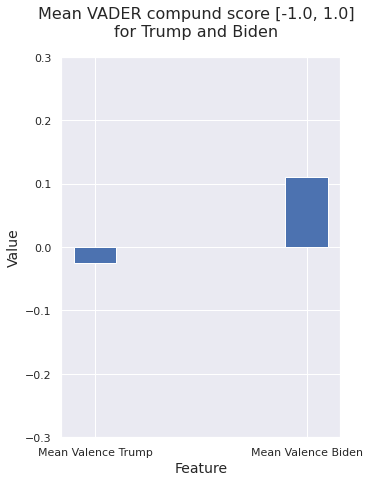

In [ ]:
print(trump_usa_df['vader_polarity'].mean())
print(biden_usa_df['vader_polarity'].mean())

fig = plt.figure(figsize=(5,7))

fig.suptitle('Mean VADER compund score [-1.0, 1.0]\nfor Trump and Biden', fontsize=16)

features = ['Mean Valence Trump', 'Mean Valence Biden']
values = [trump_usa_df['vader_polarity'].mean(), biden_usa_df['vader_polarity'].mean()]

plt.bar(features,values, width=0.2)

axes = plt.gca()
axes.set_ylim(-.3, .3)
axes.set_xlabel('Feature', fontsize = 14)
axes.set_ylabel('Value', fontsize = 14)

plt.show()

Let's explore further the differences between sentiment for the two candidates.  
We continue with visual inspection of the distribution of sentiment scores.

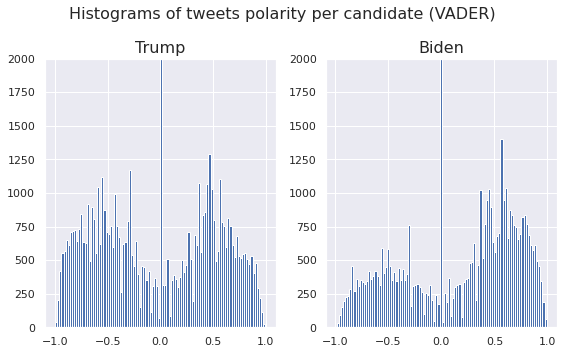

In [ ]:
bins = 100

fig, axes = plt.subplots(1, 2, figsize=(8,5))
fig.suptitle('Histograms of tweets polarity per candidate (VADER)', fontsize=16)

axes[0].hist(trump_usa_df['vader_polarity'], bins = bins)
axes[0].set_title('Trump', fontsize = 16)
#axes[0].set_xlabel('Valence', fontsize = 14)
#axes[0].set_ylabel('Relative frequency', fontsize = 14)
axes[0].set_ylim(0, 2000)

plt.hist(biden_usa_df['vader_polarity'], bins = bins)
axes[1].set_title('Biden', fontsize = 16)
#axes[0].set_xlabel('Valence', fontsize = 14)
#axes[0].set_ylabel('Relative frequency', fontsize = 14)
axes[1].set_ylim(0, 2000)

plt.tight_layout()
plt.show()

Let's try a different way to plot: maybe overlapping the two distribution in the same plot would give ore insight. 

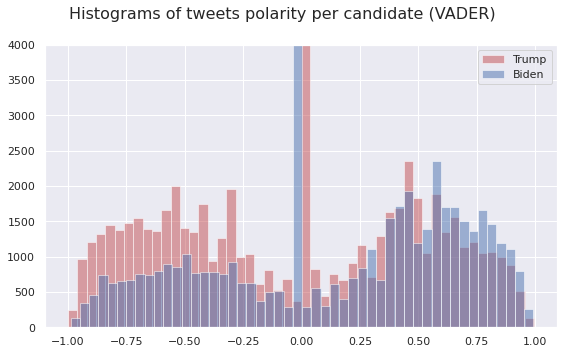

In [ ]:
bins = 50

fig = plt.figure(figsize=(8,5))
fig.suptitle('Histograms of tweets polarity per candidate (VADER)', fontsize=16)

plt.hist(trump_usa_df['vader_polarity'], bins = bins, alpha = 0.5, color = 'r')
plt.hist(biden_usa_df['vader_polarity'], bins = bins, alpha = 0.5, color = 'b')

axes = plt.gca()
axes.set_ylim(0, 4000)

labels= ["Trump", "Biden"]
axes.legend(labels)

plt.tight_layout()
plt.show()

## 3.3 Sentiment analysis using Flair

Flair is a pre-trained character-level LSTM (recurrent neural networks) classifier which takes into account:
- the sequence of words
- the sequence of letters 
- intensifiers ('so', 'very' etc)
Advantage over VADER: by looking at character level, it can recognize and correct for typos (e.g. it will recognize that 'anoy' means 'annoy'), which for VADER would just be an OOV (Out Of Vocabulary) word (and thus ignored).

Advantage over VADER: by looking at character level, it can recognize and correct for typos (e.g. it will recognize that 'anoy' means 'annoy'), which for VADER would just be an OOV (Out Of Vocabulary) word (and thus ignored).

### Pre-trained Flair models
As we lack computing power, we will use a freely available pre-trained Flair model.  

For sentiment classification, Flair offers two pre-trained models (as mentioned in one of the [official Flair tutorials on their github here](https://github.com/flairNLP/flair/blob/master/resources/docs/TUTORIAL_2_TAGGING.md)):

<style type="text/css">
	table.tableizer-table {
		font-size: 12px;
		border: 1px solid #CCC; 
		font-family: Arial, Helvetica, sans-serif;
	} 
	table.tableizer-table td {
		padding: 4px;
		margin: 3px;
		border: 1px solid black;
	}
	table.tableizer-table th {
		background-color: #104E8B; 
		color: #FFF;
		font-weight: bold;
	}
</style>

<table class="tableizer-table" style="border: 1px solid #CCC;">
<thead><tr class="tableizer-firstrow"><th>ID</th><th>Language</th><th>Task</th><th>Training Dataset</th><th>Accuracy</th></tr></thead><tbody>
 <tr><td>sentiment'</td><td>English</td><td>detecting positive and negative sentiment (transformer-based)</td><td>movie and product reviews</td><td>98.87</td></tr>
 <tr><td>sentiment-fast'</td><td>English</td><td>detecting positive and negative sentiment (RNN-based)</td><td>movie and product reviews</td><td>96.83</td></tr>
</tbody></table>
 

The pre-trained classifier of Flair was trained on **IMDB reviews database** . We don't know how well this may generalize to our tweets data.

In [ ]:
#!pip install flair
from flair.models import TextClassifier
from flair.data import Sentence
from segtok.segmenter import split_single

classifier = TextClassifier.load('en-sentiment')

/root/venv/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0
2021-05-28 10:10:45,294 https://nlp.informatik.hu-berlin.de/resources/models/sentiment-curated-distilbert/sentiment-en-mix-distillbert_4.pt not found in cache, downloading to /tmp/tmpjxvw8kiz
100%|██████████| 265512723/265512723 [00:24<00:00, 10882609.16B/s]2021-05-28 10:11:10,059 copying /tmp/tmpjxvw8kiz to cache at /root/.flair/models/sentiment-en-mix-distillbert_4.pt

2021-05-28 10:11:10,290 removing temp file /tmp/tmpjxvw8kiz
2021-05-28 10:11:10,312 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

Example of how to use Flair classifier to predict for one sentence.

In [ ]:
sentence = Sentence('The food was not horrible!')
classifier.predict(sentence)

# print sentence with predicted labels
print('Sentence above is: ', sentence.labels)

Sentence above is:  [POSITIVE (0.9715)]


Helper functions for performing the sentiment analysis using Flair

In [ ]:
'''we need a custom cleaning function, because we only want to remove a restricted set of characters / tags:
- hyperlinks
- end of line / new line characters
- some html tags and their decimal equivalent 
'''
def clean(raw):
    """ Remove hyperlinks and markup """
    result = re.sub("<[a][^>]*>(.+?)</[a]>", 'Link.', raw)
    result = re.sub('&gt;', "", result)    # html >
    result = re.sub('&lt;', "", result)    # html <
    result = re.sub('&#x27;', "'", result) # Apostrophe
    result = re.sub('&quot;', '"', result) # Quote punctuation
    result = re.sub('&#x2F;', ' ', result) # /
    result = re.sub('<p>', ' ', result)    # html <p> tag
    result = re.sub('</i>', '', result)    # html </i> tag
    result = re.sub('&#62;', '', result)   # decimal >
    result = re.sub('<i>', ' ', result)    # html <i> tag
    result = re.sub("\n", '', result)      # new line
    return result

def flair_make_sentences(text):
    """ Break apart text into a list of sentences """
    sentences = [sent for sent in split_single(text)]
    return sentences

def flair_predict_sentences(sentence):
    """ Predict the sentiment of a sentence """
    if sentence == "":
        return 0
    text = Sentence(sentence)
    # stacked_embeddings.embed(text)
    classifier.predict(text)
    value = text.labels[0].to_dict()['value'] 
    if value == 'POSITIVE':
        result = text.to_dict()['labels'][0]['confidence']
    else:
        result = -(text.to_dict()['labels'][0]['confidence'])
    return round(result, 3)

def flair_get_scores_per_sentences(sentences):
    """ Call predict on every sentence of a text """
    results = []
    
    for i in range(0, len(sentences)): 
        results.append(flair_predict_sentences(sentences[i]))
    results.append(flair_predict_sentences(sentences[0]))
    return results

def flair_get_sum(scores):
    result = round(sum(scores), 3)
    return result

def flair_get_avg_from_sentences(scores):
    result = round(np.mean(scores), 3)
    return result

classifier = TextClassifier.load('en-sentiment')
def flair_get_score_tweet(text):
  if not text:
    return 0
  s = Sentence(text)
  classifier.predict(s)
  value = s.labels[0].to_dict()['value'] 
  if value == 'POSITIVE':
    result = s.to_dict()['labels'][0]['confidence']
  else:
    result = -(s.to_dict()['labels'][0]['confidence'])
  return round(result, 3)

def sentiment_analysis_flair(polarity):
  if polarity > 0:
    return 'positive'
  if polarity == 0:
    return 'neutral'
  if polarity < 0:
    return 'positive'

2021-01-21 10:23:25,909 loading file /home/jovyan/.flair/models/sentiment-en-mix-distillbert_3.1.pt


Let's explore the Flair results in the context of a comparison between all three methods.

## 3.4 Sentiment prediction: comparison between TextBlob, VADER and Flair

1. TextBlob
2. VADER
3. Flair per sentence
4. Flair per tweet

Our dataset is not labelled, so there is no way for us to compare predictions to some 'ground truth'.  
We will, instead, compare predictions of the three algorithms we have used.  

But first we will explore and compare sentiment labelling for two ways to use Flair and here is why.  
We asked oursleved what is the best way to perform prediction for Tweet ?   
- option 1: Should we predict on the whole Tweet ?  
- option 2: Should we split into sentences, predict for each sentence and then make an average ?

As we did not find clear indications for this in the official [Flair documentation](https://github.com/flairNLP/flair), we will explore both methods. 

In [ ]:
records = 1000
temp = twitter_usa_df[twitter_usa_df.initial_dataset=='trump'][:records].copy()

import time
start = time.time()

#flair sentiment by diving tweet into sentenes and averaging
temp['sentences'] = temp['clean_tweet_nltk'].apply(flair_make_sentences)
temp['scores'] = temp['sentences'].apply(flair_get_scores_per_sentences)
temp['flair_scores_avg'] = temp.scores.apply(flair_get_avg_from_sentences)

#flair sentiment on the whole tweet
temp['flair_one_score'] = temp['clean_tweet_nltk'].apply(flair_get_score_tweet)

stop = time.time()
print(round((stop-start)/60, 3))

NameError: name 'flair_make_sentences' is not defined

KeyError: 'flair_scores_avg'

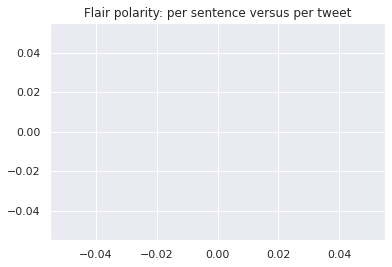

In [ ]:
bins = 50
alpha = 0.6
fig = plt.plot(figsize=(6,5))

plt.title('Flair polarity: per sentence versus per tweet')
ax = plt.gca()

ax.hist(temp['flair_scores_avg'], bins = bins, alpha = alpha, color = 'r')
ax.hist(temp['flair_one_score'], bins = bins, alpha = alpha, color = 'g')
ax.set_ylim(0, 100)
labels= ["Flair sentences", "Flair tweet"]
ax.legend(labels)
plt.show()

The above plot shows that the two methods for computing polarity of a tweet with Flair produce exactly the same results.

## Comprison of the three sentiment analysis libraries

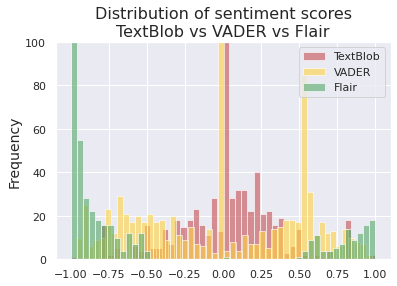

In [ ]:
bins = 50
alpha = 0.6
fig = plt.plot(figsize=(8,7))

plt.title('Distribution of sentiment scores\nTextBlob vs VADER vs Flair', fontsize=16)

ax = plt.gca()

ax.hist(temp['blob_polarity'], bins = bins, alpha = alpha, color = 'r')
ax.hist(temp['vader_polarity'], bins = bins, alpha = alpha, color = '#ffd343')
ax.hist(temp['flair_one_score'], bins = bins, alpha = alpha, color = 'g')
ax.set_ylim(0, 100)
labels= ["TextBlob", "VADER", "Flair"]
ax.legend(labels)

ax.set_ylabel('Frequency', fontsize = 14)

#fig.tight_layout(rect=[0, 0.03, 1, 0.9])
plt.show()

Let's see the percentage of times these algorithms agree with one another when classifying the sentiment of a tweet.

In [ ]:
temp['flair_sentiment'] = temp['flair_one_score'].apply(sentiment_analysis_flair)

In [ ]:
from sklearn.metrics import accuracy_score

print(f"Consensus TextBlob - VADER: {accuracy_score(temp['blob_sentiment'],temp['vader_sentiment']):.4}")
print(f"Consensus TextBlob - Flair: {accuracy_score(temp['blob_sentiment'],temp['flair_sentiment']):.4}")
print(f"Consensus VADER - Flair: {accuracy_score(temp['vader_sentiment'],temp['flair_sentiment']):.4}")

Consensus TextBlob - VADER: 0.555
Consensus TextBlob - Flair: 0.301
Consensus VADER - Flair: 0.359


The results above indicate two possibilities:

    - either all algorithms are wrong a lot of times
    - or just two of them are mostly wrong and one does a good job.

Unfortunately, we know of no other way to automatically compare performance, so we will visualize a few examples where they all disagree.


In [ ]:
def consensus(row):
  count = 0
  count += row['blob_sentiment']==row['vader_sentiment']
  count += row['blob_sentiment']==row['flair_sentiment']
  count += row['vader_sentiment']==row['flair_sentiment']

  return count

temp['consensus'] = temp.apply(lambda row: consensus(row), axis=1)

print(temp['consensus'].value_counts())

1    696
3    173
0    131
Name: consensus, dtype: int64


In [ ]:
(temp[temp['consensus']==0])[['tweet', 'clean_tweet_nltk', 'blob_sentiment', 'vader_sentiment', 'flair_sentiment']].tail(20)

,tweet,clean_tweet_nltk,blob_sentiment,vader_sentiment,flair_sentiment
1033,#NBCboycott @NBCNews fire #ChuckTodd and move ...,nbcboycott chucktodd town hall trump,neutral,negative,positive
1035,All these people upset because #IceCube is wor...,people upset icecube work trump maybe problem ...,neutral,negative,positive
1050,Head Thread. #Trump &amp; co. keep committing...,head thread trump amp commit manner fraud libe...,neutral,negative,positive
1056,@business @bsurveillance : @tomkeene &amp; @fl...,amp stephanie compare trump performance record...,neutral,negative,positive
1059,"@FLOTUS @realDonaldTrump Smh...no doubt, #dona...",smh doubt donaldtrump trick hushmoney,neutral,negative,positive
1063,@FLOTUS @realDonaldTrump This is how #donaldtr...,donaldtrump get money pocket steal kid cancer ...,neutral,negative,positive
1065,@realDonaldTrump No doubt...garbage.\nDesperat...,doubt garbage desperation donaldtrump amp lack...,neutral,negative,positive
1069,@GOP @realDonaldTrump This is how #donaldtrump...,donaldtrump get money pocket steal kid cancer ...,neutral,negative,positive
1070,@realDonaldTrump This is how #donaldtrump gets...,donaldtrump get money pocket steal kid cancer ...,neutral,negative,positive
1083,"""Cory Booker is an actual Rhodes Scholar — as ...",cory booker actual rhodes scholar award rhodes...,neutral,negative,positive


## Observations for comparison between TextBlob, VADER and Flair

We notice that TextBlob and VADER tend to:  
- classify a lot of the data as neutral
VADER has a bimodal distribution, while TextBlob is unimodal. 

Flair:  
- has no predilection for neutral. 
- and is extremly polarizing, compared to TextBlob or VADER

Regarding the lack of a strong neutral category in Flair (compare it to TextBlob and VADER for example), [Flair co-creator, Alan Akbik,](https://youtu.be/5Hg18QxU6mA?t=2481) explains that when Flair sentiment analysis model was trained on reviews dataset and there was too much variability in people's attitudes in the middle, which prevented the model from learning something useful for a rating that translates to 'average'.

Some people would give an average rating if the product/service has some shortcomings, while others would punish with an average rating if it was a complete disapointment.  
According to Alan Akbik, they ended up training only on more extreme reviews, to avoid the middle reviews with very low signal to noise ration.  

Based on the distribution plots and after inspecting a few tweets where all three algorithms applied different labels, we decide to use in further analyses the results from **VADER**


# 3.5 Predicting election results

### Independent variables 
We identified several independent variables that were used in the literature to predict election results from:  
-  \[1] successfully predicted results of German federal elections for national parliament from share of Tweets alone  
-  \[2] shows correlation between sentiment expressed in Tweets and traditional polling results.  

Problems with method 1: Simply counting the number of tweets with #Trump or #Biden is not very relevant. As we've seen in section 3.1 and 3.2, a high portions of tweets mentioning one candidate are actually negative (against the cadidate).
We will therefore only consider sentiment extracted from Tweets.

### One vote per resident  
When analysing 2014 election results, \[3] found there are Trump supporters who produce a large number of Tweets. It would not make sense to count each of these tweets (or the positive/negative sentiment of each). We will thus compute an average per user so that each user counts towards one vote.

Methods found in the literature:  
- \[4] considered for analysis only users that tweeted one single election related tweet in the period of time of the data collection.


**\[1]** Tumasjan, A.; Sprenger, T.; Sandner, P. G.; and Welpe, I. M. 2010. Predicting elections with twitter: What 140 characters reveal about political sentiment. In Proc. of 4th ICWSM,
178–185. AAAI Press.  
**\[2]** O’Connor, B.; Balasubramanyan, R.; Routledge, B. R.; and Smith, N. A. 2010. From tweets to polls: Linking text sentiment to public opinion time series. In Proc. of 4th ICWSM,
122–129. AAAI Press.  
**\[3]** Alexandre Bovet, Flaviano Morone, and Hernán A Makse. 2018. Validation of Twitter opinion trends with national polling aggregates: Hillary
Clinton vs Donald Trump. Scientific reports 8, 1 (2018), 1–16.  
**\[4]** Jessica Elan Chung and Eni Mustafaraj. 2011. Can collective sentiment expressed on twitter predict political elections?. In Twenty-Fifth AAAI
Conference on Artificial Intelligence.



# 4. Valence distribution of tweets over US States

In [ ]:
# Helper Function
def conv_relFreq(df, feature, feat_sum):
    df[f'{feature}_relFreq'] = df[feature] / df[feat_sum] 

##### Trump Dataset

In [ ]:
# group valency of tweets per state
grouped_state_trump_usa_df = pd.concat([trump_usa_df['State'],pd.get_dummies(trump_usa_df['vader_comp_score'], prefix='score')],axis=1)

KeyError: 'vader_comp_score'

In [ ]:
grouped_state_trump_usa_df = grouped_state_trump_usa_df.groupby(by=['State']).sum().reset_index()
grouped_state_trump_usa_df.head()

NameError: name 'grouped_state_trump_usa_df' is not defined

In [ ]:
# Soth Dakota is missing 
grouped_state_trump_usa_df.shape

(51, 4)

In [ ]:
grouped_state_trump_usa_df = grouped_state_trump_usa_df.append({'State': 'South Dakota', 'score_negative': 0, 'score_neutral': 0, 'score_positive': 0}, ignore_index=True)
grouped_state_trump_usa_df = grouped_state_trump_usa_df.sort_values(by=['State'])
grouped_state_trump_usa_df = grouped_state_trump_usa_df.reset_index(drop=True)

In [ ]:
grouped_state_trump_usa_df['sum_tweets_state'] = grouped_state_trump_usa_df['score_negative'] + grouped_state_trump_usa_df['score_neutral'] + grouped_state_trump_usa_df['score_positive'] 

In [ ]:
conv_relFreq(grouped_state_trump_usa_df,'score_negative','sum_tweets_state')
conv_relFreq(grouped_state_trump_usa_df,'score_neutral','sum_tweets_state')
conv_relFreq(grouped_state_trump_usa_df,'score_positive','sum_tweets_state')

##### Biden Dataset

In [ ]:
grouped_state_biden_usa_df = pd.concat([biden_usa_df['State'],pd.get_dummies(biden_usa_df['vader_comp_score'], prefix='score')],axis=1)

In [ ]:
grouped_state_biden_usa_df = grouped_state_biden_usa_df.groupby(by=['State']).sum().reset_index()
grouped_state_biden_usa_df.head()

,State,score_negative,score_neutral,score_positive
0,Alabama,52.0,78.0,97.0
1,Alaska,27.0,31.0,42.0
2,Arizona,404.0,517.0,629.0
3,Arkansas,8.0,30.0,23.0
4,California,2968.0,4845.0,5482.0


In [ ]:
grouped_state_biden_usa_df['sum_tweets_state'] = grouped_state_biden_usa_df['score_negative'] + grouped_state_biden_usa_df['score_neutral'] + grouped_state_biden_usa_df['score_positive'] 

In [ ]:
conv_relFreq(grouped_state_biden_usa_df,'score_negative','sum_tweets_state')
conv_relFreq(grouped_state_biden_usa_df,'score_neutral','sum_tweets_state')
conv_relFreq(grouped_state_biden_usa_df,'score_positive','sum_tweets_state')

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator


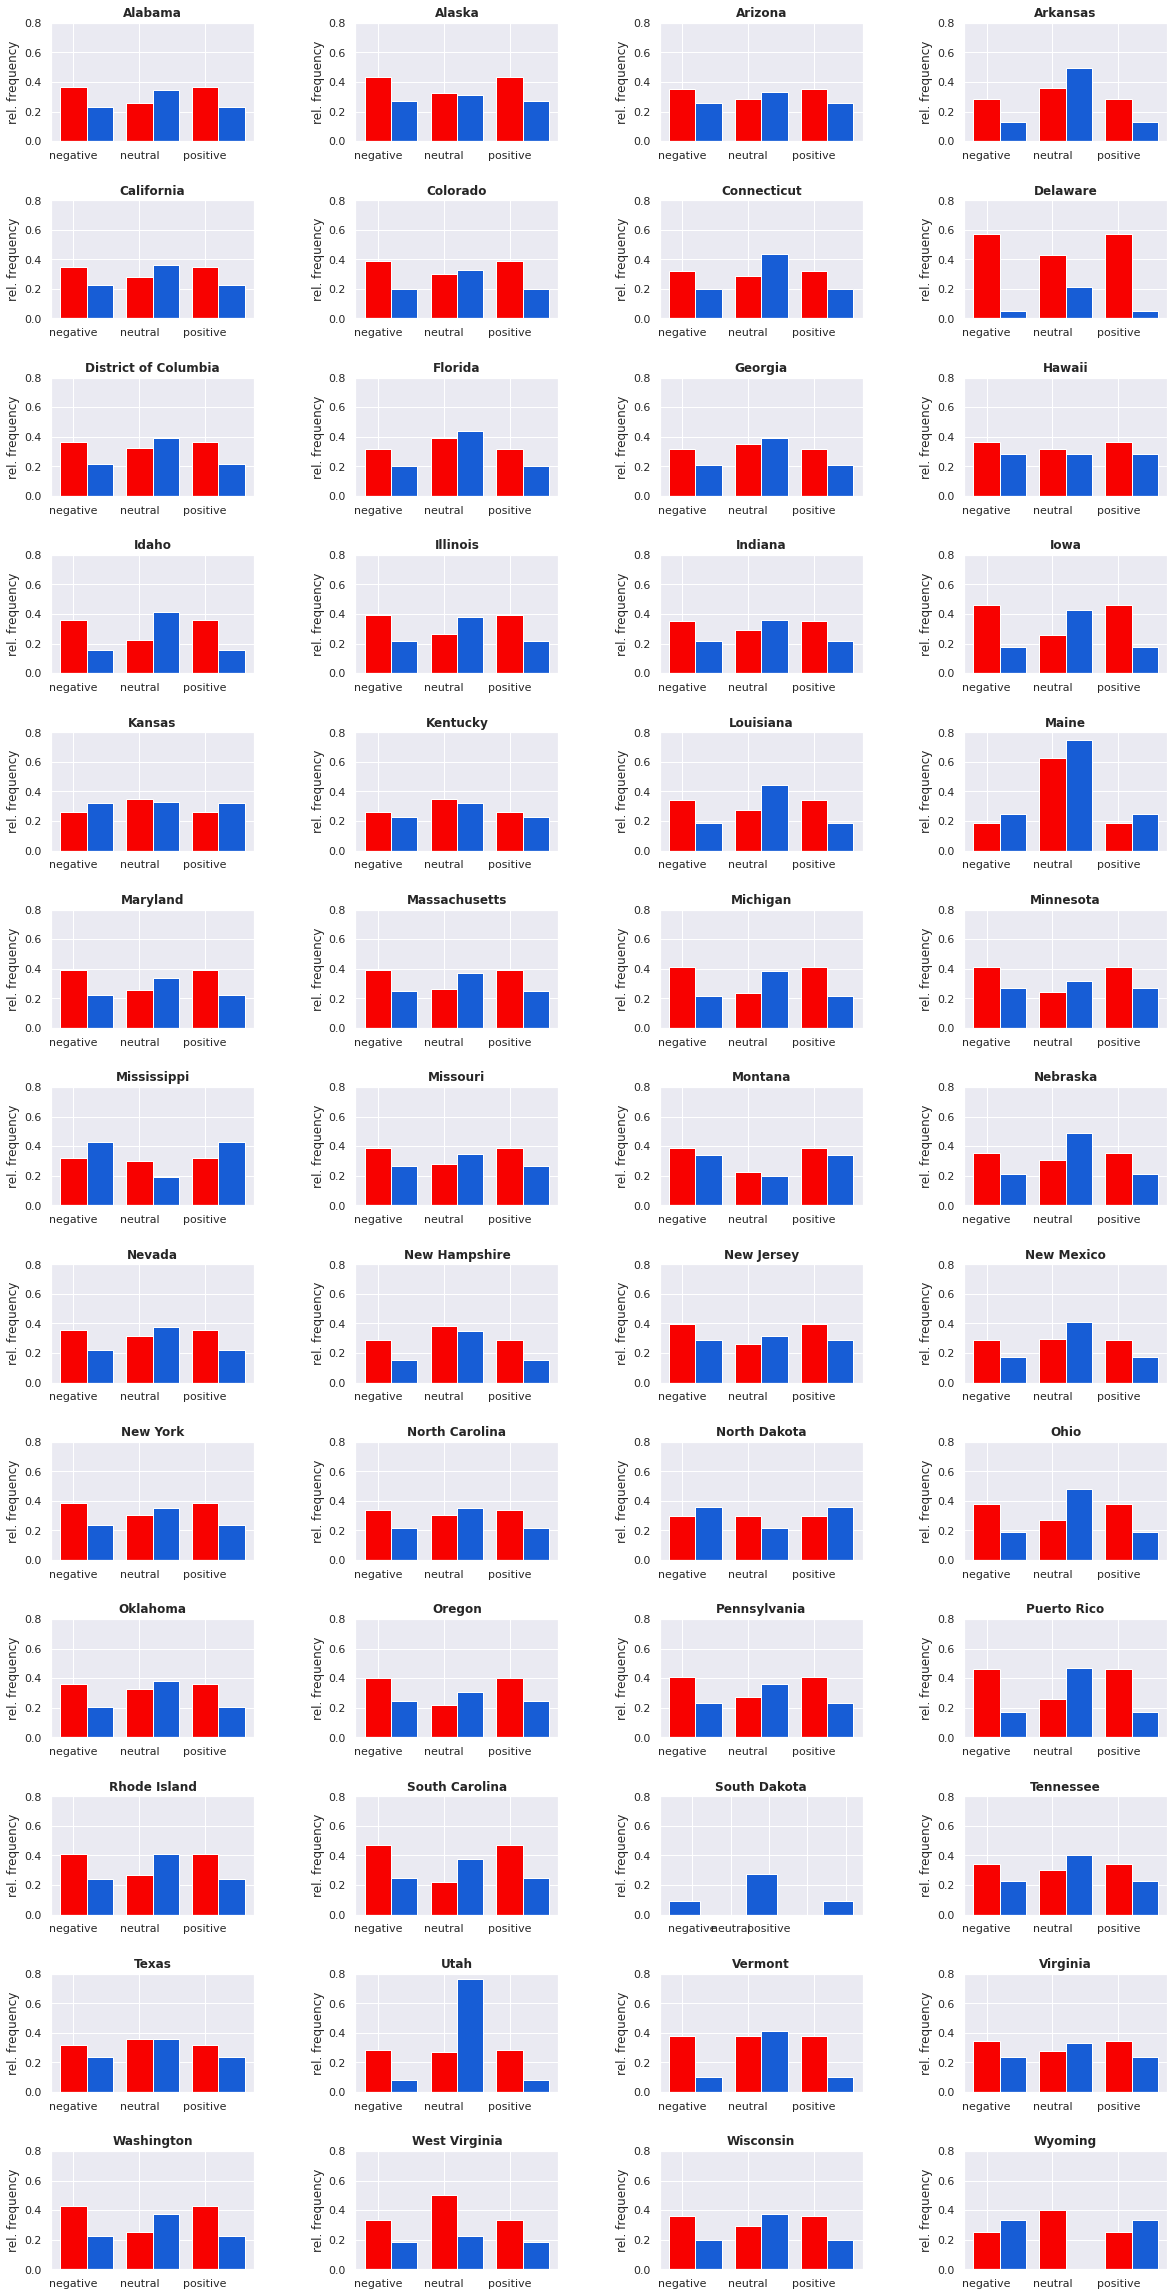

In [ ]:
target_columns = ['State','score_negative_relFreq','score_neutral_relFreq','score_positive_relFreq']
data_trump = grouped_state_trump_usa_df[target_columns]
data_biden = grouped_state_biden_usa_df[target_columns]
states = data_biden["State"]

barWidth = 0.4
columns = 4
rows = 13

fig, ax_array = plt.subplots(rows, columns,squeeze=False, figsize=(20,80))

cnt = 0

for i,ax_row in enumerate(ax_array):
    for j,axes in enumerate(ax_row):

        target_trump = data_trump.loc[data_trump.State==states[cnt]]
        target_biden = data_biden.loc[data_biden.State==states[cnt]]

        b1 = [ target_trump['score_negative_relFreq'].values[0], target_trump['score_neutral_relFreq'].values[0], target_trump['score_negative_relFreq'].values[0] ]
        b2 = [ target_biden['score_negative_relFreq'].values[0], target_biden['score_neutral_relFreq'].values[0], target_biden['score_negative_relFreq'].values[0] ]

        # Set position of bar on X axis
        r1 = np.arange(len(b1))
        r2 = [x + barWidth for x in r1]

        axes.bar(r1, b1, color='#f80100', width=barWidth, edgecolor='white', label='trump')
        axes.bar(r2, b2, color='#175dd6', width=barWidth, edgecolor='white', label='biden')
        
        axes.set_title(f'{states[cnt]}', fontweight='bold')
        axes.set_xticklabels(['','negative','neutral','positive'])
        axes.set_ylabel('rel. frequency')
        axes.set_ylim(0, .8)
    
        cnt = cnt + 1

plt.subplots_adjust(top = 0.4, bottom=0.01, hspace=0.5, wspace=0.5)
plt.show()

#### Geographical distribution of Valence over states

In [ ]:
geo_trump_df = pd.merge(geo_usa_df, grouped_state_trump_usa_df[['State','score_negative_relFreq','score_neutral_relFreq','score_positive_relFreq']], on='State')
geo_biden_df = pd.merge(geo_usa_df, grouped_state_biden_usa_df[['State','score_negative_relFreq','score_neutral_relFreq','score_positive_relFreq']], on='State')

In [ ]:
geo_biden_df.shape
geo_trump_df.shape

(52, 13)

In [ ]:
#geo_biden_df.to_json('geo_biden_df.json',orient='records')
#geo_trump_df.to_json('geo_trump_df.json',orient='records')

Biden Negativity  | Trump Negativity
--- | ---
![](geo_visualization/biden_map_negativity.jpg) | ![](geo_visualization/trump_map_negativity.jpg)


Biden Neutrality  | Trump Neutrality
--- | ---
![](geo_visualization/biden_map_neutrality.jpg) | ![](geo_visualization/trump_map_neutrality.jpg)


Biden Positivity  | Trump Positivity
--- | ---
![](geo_visualization/biden_map_positivity.jpg) | ![](geo_visualization/trump_map_positivity.jpg)


## 5. Topic modeling: Latent Dirichlet Allocation (LDA)


LDA is an unsupervised machine learning algorithm. It allows a set of observations to be explained by unobserved groups that explain similarities within the data.

![Picture title](image-20210120-154824.png)

We will use the topic modeling to create and visualize the topics which shape the discourse around the elections. 
We start with finding the optimal number of topics for our dataset. Trying out the different numbers of topics and comparing the coherence score for each model.

In [ ]:
#subseting and preparing data for TM
data_sample = twitter_usa_df.sample(n = 1000)

In [ ]:

# Create Dictionary
tweets_dictionary = corpora.Dictionary(data_sample.tokenized_tweets)

# Create Corpus
texts = twitter_usa_df.tokenized_tweets

# Term Document Frequency
tweets_corpus = [tweets_dictionary.doc2bow(text) for text in texts]

# compute coherence
tweets_coherence = []
for nb_topics in range(1,21):
    lda = LdaModel(tweets_corpus, num_topics = nb_topics, id2word = tweets_dictionary, passes=10,random_state=100)
    #cohm = CoherenceModel(model=lda, corpus=tweets_corpus, dictionary=tweets_dictionary, coherence='u_mass') #u_mass
    cohm = CoherenceModel(model=lda, texts=twitter_usa_df.tokenized_tweets, dictionary=tweets_dictionary, coherence='c_v') 
    coh = cohm.get_coherence()
    tweets_coherence.append(coh)

# visualize coherence
plt.figure(figsize=(10,5))
plt.plot(range(1,21),tweets_coherence)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")



KeyboardInterrupt: 

KernelInterrupted: Execution interrupted by the Jupyter kernel.

Exception ignored in: <function tqdm.__del__ at 0x7f0d75fea950>
Traceback (most recent call last):
  File "/shared-libs/python3.7/py/lib/python3.7/site-packages/tqdm/std.py", line 1145, in __del__
    self.close()
  File "/shared-libs/python3.7/py/lib/python3.7/site-packages/tqdm/notebook.py", line 283, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm' object has no attribute 'disp'


KernelInterrupted: Execution interrupted by the Jupyter kernel.

The optional number of topics according to the coherence score is 12.

In [ ]:
vectorizer = CountVectorizer( analyzer='word',       
min_df=3,# minimum required occurences of a word 
stop_words='english',# remove stop words
lowercase=True,# convert all words to lowercase
token_pattern='[a-zA-Z0-9]{3,}',# num chars > 3
max_features=5000,# max number of unique words
)


In [ ]:
data_matrix = vectorizer.fit_transform(twitter_usa_df.lemmat_tweets)
data_matrix

<152376x5000 sparse matrix of type '<class 'numpy.int64'>'
	with 1156780 stored elements in Compressed Sparse Row format>

In [ ]:
lda_model = LatentDirichletAllocation(
n_components=12, # Number of topics
learning_method='online',
random_state=62,       
n_jobs = -1  # Use all available CPUs
)

lda_output = lda_model.fit_transform(data_matrix)

In [ ]:
pyLDAvis.enable_notebook()
p = pyLDAvis.sklearn.prepare(lda_model, data_matrix, vectorizer, mds='tsne')
pyLDAvis.save_html(p, 'lda.html')

NameError: name 'pyLDAvis' is not defined

In [ ]:
p

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
5        5.310529  171.049652       1        1  10.527503
2      136.304657   23.800941       2        1  10.007987
10     101.190552  -84.985191       3        1   9.814504
1     -106.824867  148.841736       4        1   9.273759
4      -44.365761   78.632721       5        1   9.176709
6       43.884090   73.474022       6        1   8.509721
11     114.093971  135.933029       7        1   8.406253
7     -119.727142  -72.077179       8        1   8.343938
9      -49.518208   -9.617325       9        1   7.227398
3     -141.938736   40.055210      10        1   6.811505
0       38.731544  -14.776019      11        1   6.382780
8      -10.944340 -107.193344      12        1   5.517942, topic_info=                   Term          Freq         Total Category  logprob  loglift
3476          president  16194.000000  16194.000000  Default  30.0000  30.0000
4900                win  13523.000000  13523.000000  Default  29.0000  29.0000
2460       kamalaharris   7627.000000   7627.000000  Default  28.0000  28.0000
891                come   4830.000000   4830.000000  Default  27.0000  27.0000
4236              state   5868.000000   5868.000000  Default  26.0000  26.0000
...                 ...           ...           ...      ...      ...      ...
3030  negligenthomicide    543.031278    543.975303  Topic12  -4.8204   2.8954
2977    murdererinchief    539.041779    539.985804  Topic12  -4.8278   2.8954
1015        coronavirus   1244.308486   1744.106985  Topic12  -3.9912   2.5595
3232           pandemic   1019.429142   1371.242385  Topic12  -4.1906   2.6007
4234              start   1238.499724   1937.730689  Topic12  -3.9959   2.4495

[505 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
0         6  0.999629         000
2         4  0.998449         100
22       11  0.999498        2016
26        1  0.999910        2020
50        1  0.998516         270
...     ...       ...         ...
4977      3  0.579033        year
4977      4  0.255890        year
4980      2  0.999220         yes
4984     12  0.999053        york
4988      2  0.998173  yourefired

[556 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 3, 11, 2, 5, 7, 12, 8, 10, 4, 1, 9])

In [ ]:
for i,topic in enumerate(lda_model.components_):
    print(f'Top 10 words for topic #{i + 1}:')
    print([vectorizer.get_feature_names()[i] for i in topic.argsort()[-10:]])
    print('\n')

Top 10 words for topic #1:
['leader', 'corruption', 'nevada', 'gop', 'politics', 'video', 'real', 'georgia', 'ballot', 'hunter']


Top 10 words for topic #2:
['united', 'medium', 'michigan', 'believe', 'look', 'people', 'country', 'news', 'need', 'state']


Top 10 words for topic #3:
['people', 'mail', 'today', 'man', 'work', 'obama', 'american', 'count', 'pennsylvania', 'let']


Top 10 words for topic #4:
['time', 'gon', 'matter', 'turn', 'thing', 'hear', 'kamala', 'win', 'life', 'good']


Top 10 words for topic #5:
['like', 'lose', 'poll', 'time', 'talk', 'debate', 'try', 'maga', 'know', 'win']


Top 10 words for topic #6:
['tax', 'cnn', 'que', 'china', 'hope', 'usa', 'day', 'elect', '2020', 'president']


Top 10 words for topic #7:
['arizona', 'party', 'florida', 'stop', 'covid', '000', 'covid19', 'win', 'republican', 'democrat']


Top 10 words for topic #8:
['racist', 'fraud', 'guy', 'say', 'speech', 'presidential', 'house', 'white', 'lie', 'presidentelect']


Top 10 words for topi

## 5.1 Predictive model for the new tweets

In the last step, we add a new created topic column to the input dataframe and assign to each row ,based on the probability value, the suitable topic. To find the topic index with maximum value, we can call the argmax() method and pass 1 as the value for the axis parameter.

In [ ]:
topic_values = lda_model.transform(data_matrix)
twitter_usa_df['Topic'] = topic_values.argmax(axis=1)

Let’s see which topic has been assigned to each tweet

In [ ]:
twitter_usa_df[['tweet', 'Topic']].head(5)

,tweet,Topic
0,"#Trump: As a student I used to hear for years, for ten years, I heard China! In 2019! And we have 1.5 and they don't know how many we have and I asked them how many do we have and they said 'sir we don't know.' But we have millions. Like 300 million.\n\nUm. What?",5
1,You get a tie! And you get a tie! #Trump ‘s rally #Iowa https://t.co/jJalUUmh5D,0
3,#Trump #PresidentTrump #Trump2020LandslideVictory #Trump2020 #MAGA #KAG #4MoreYears #America #AmericaFirst #AllLivesMatter #Winning #Vote #VoteInPerson #VoteTrump #VotePresidentTrump https://t.co/TzXBKOvgNs,4
4,"#Trump: Nobody likes to tell you this, but some of the farmers were doing better the way I was doing it than they were by working their asses off.\n\nAnd that check? It's totally in the mail, right Don?",2
6,@karatblood @KazePlays_JC Grab @realDonaldTrump by the balls &amp; chuck the bastard out the door onto #PennsylvaniaAvenue &amp; form a line &amp; everybody gets to kick #DonaldTrump in the nuts! Please note 1 kick per person only! #BidenHarrisToSaveAmerica #VoteBlueToSaveOurDemocracy,0
7,Who does #trump owe 420 million dollars to? What are the terms? Who is #DonaldTrump beholden to? WE DEMAND TO KNOW!\n#TrumpIsANationalSecurityRisk \n#FollowTheMoney \n#TrumpTaxCheat \n#TrumpTaxFraud,4
8,"#TheWeek: ""#Trump in Penn: ""I saved suburbia. I got rid of a regulation that was a disaster and it was really unfair and it's gotten a lot worse under Obama and Biden. You damn well better vote for me Pennsylvania, you better vote."" But he never did identify the 'regulation.' https://t.co/7CX0PBJ2hA",2
9,#TheReidOut \n\nAm I suppose to feel badly for @OMAROSA? Isn't she the person who once claimed #Trump critics would have to bow at the feet of Donald? Sorry the snakes deserve one another. \n\n@JoyAnnReid,8
10,I have lost track of what #Trump is talking about. So has Trump.,4
12,@glennkirschner2 So basically the American experiment has failed ; we have no power we are just at the mercy to theses people .. not just Trump but the people who are down for his agenda ; because let’s not pretend #Trump hasn’t done anything that the isn’t on the GOP’s wish list ..,2


### 5.2 Testing the predicitve model on the rest of the tweets 
Here we need to split the data for two time periods and train the model and test it on the rest of the tweets as Emmanuel suggested. 


Resourse:
https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/

In [ ]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=100):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=100)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,...,Word 90,Word 91,Word 92,Word 93,Word 94,Word 95,Word 96,Word 97,Word 98,Word 99
Topic 0,hunter,ballot,georgia,real,video,politics,gop,nevada,corruption,leader,...,ignorant,ladygaga,asian,common,sex,urge,sing,neighbor,wednesday,dealing
Topic 1,state,need,news,country,people,look,believe,michigan,medium,united,...,george,enemy,responsible,staff,potus,dream,compromise,virginia,ticket,dementia
Topic 2,let,pennsylvania,count,american,obama,work,man,today,mail,people,...,orange,completely,totally,actually,special,censor,scandal,visit,behavior,train
Topic 3,good,life,win,kamala,hear,thing,turn,matter,gon,time,...,hard,water,double,60minutes,clear,ground,cbs,seek,disgrace,coup
Topic 4,win,know,maga,try,debate,talk,time,poll,lose,like,...,everybody,simple,count,rock,mess,information,nominee,mad,stupid,pres
Topic 5,president,2020,elect,day,usa,hope,china,que,cnn,tax,...,estados,die,catholic,female,doubt,economic,company,historic,decide,mass
Topic 6,democrat,republican,win,covid19,000,covid,stop,florida,party,arizona,...,fear,currently,normal,clown,superspreader,thanks,democrats,carolina,suck,star
Topic 7,presidentelect,lie,white,house,presidential,speech,say,guy,fraud,racist,...,park,math,roll,ally,immediately,workload,conference,climatechange,bed,level
Topic 8,come,new,dump,blm,lead,fuck,feel,anti,claim,case,...,cap,seal,wewon,cozy,rage,insanity,saturdayvibes,220,operation,baseless
Topic 9,end,care,bluewave,demvoice1,person,child,truth,political,lol,red,...,lockdown,involve,angry,church,notice,repeat,sun,smile,period,speaks


Creating the functions to clean, lemmatize and vectorize new text.

In [ ]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True)) 

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

# Define function to predict topic for a given text document.
def predict_topic(text, nlp=nlp):
    global sent_to_words
    global lemmatization

    # Step 1: Clean with simple_preprocess
    mytext_2 = list(sent_to_words(text))

    # Step 2: Lemmatize
    mytext_3 = lemmatization(mytext_2, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

    # Step 3: Vectorize transform
    mytext_4 = vectorizer.transform(mytext_3)

    # Step 4: LDA Transform
    topic_probability_scores = lda_model.transform(mytext_4)
    topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), :].values.tolist()
    return topic, topic_probability_scores

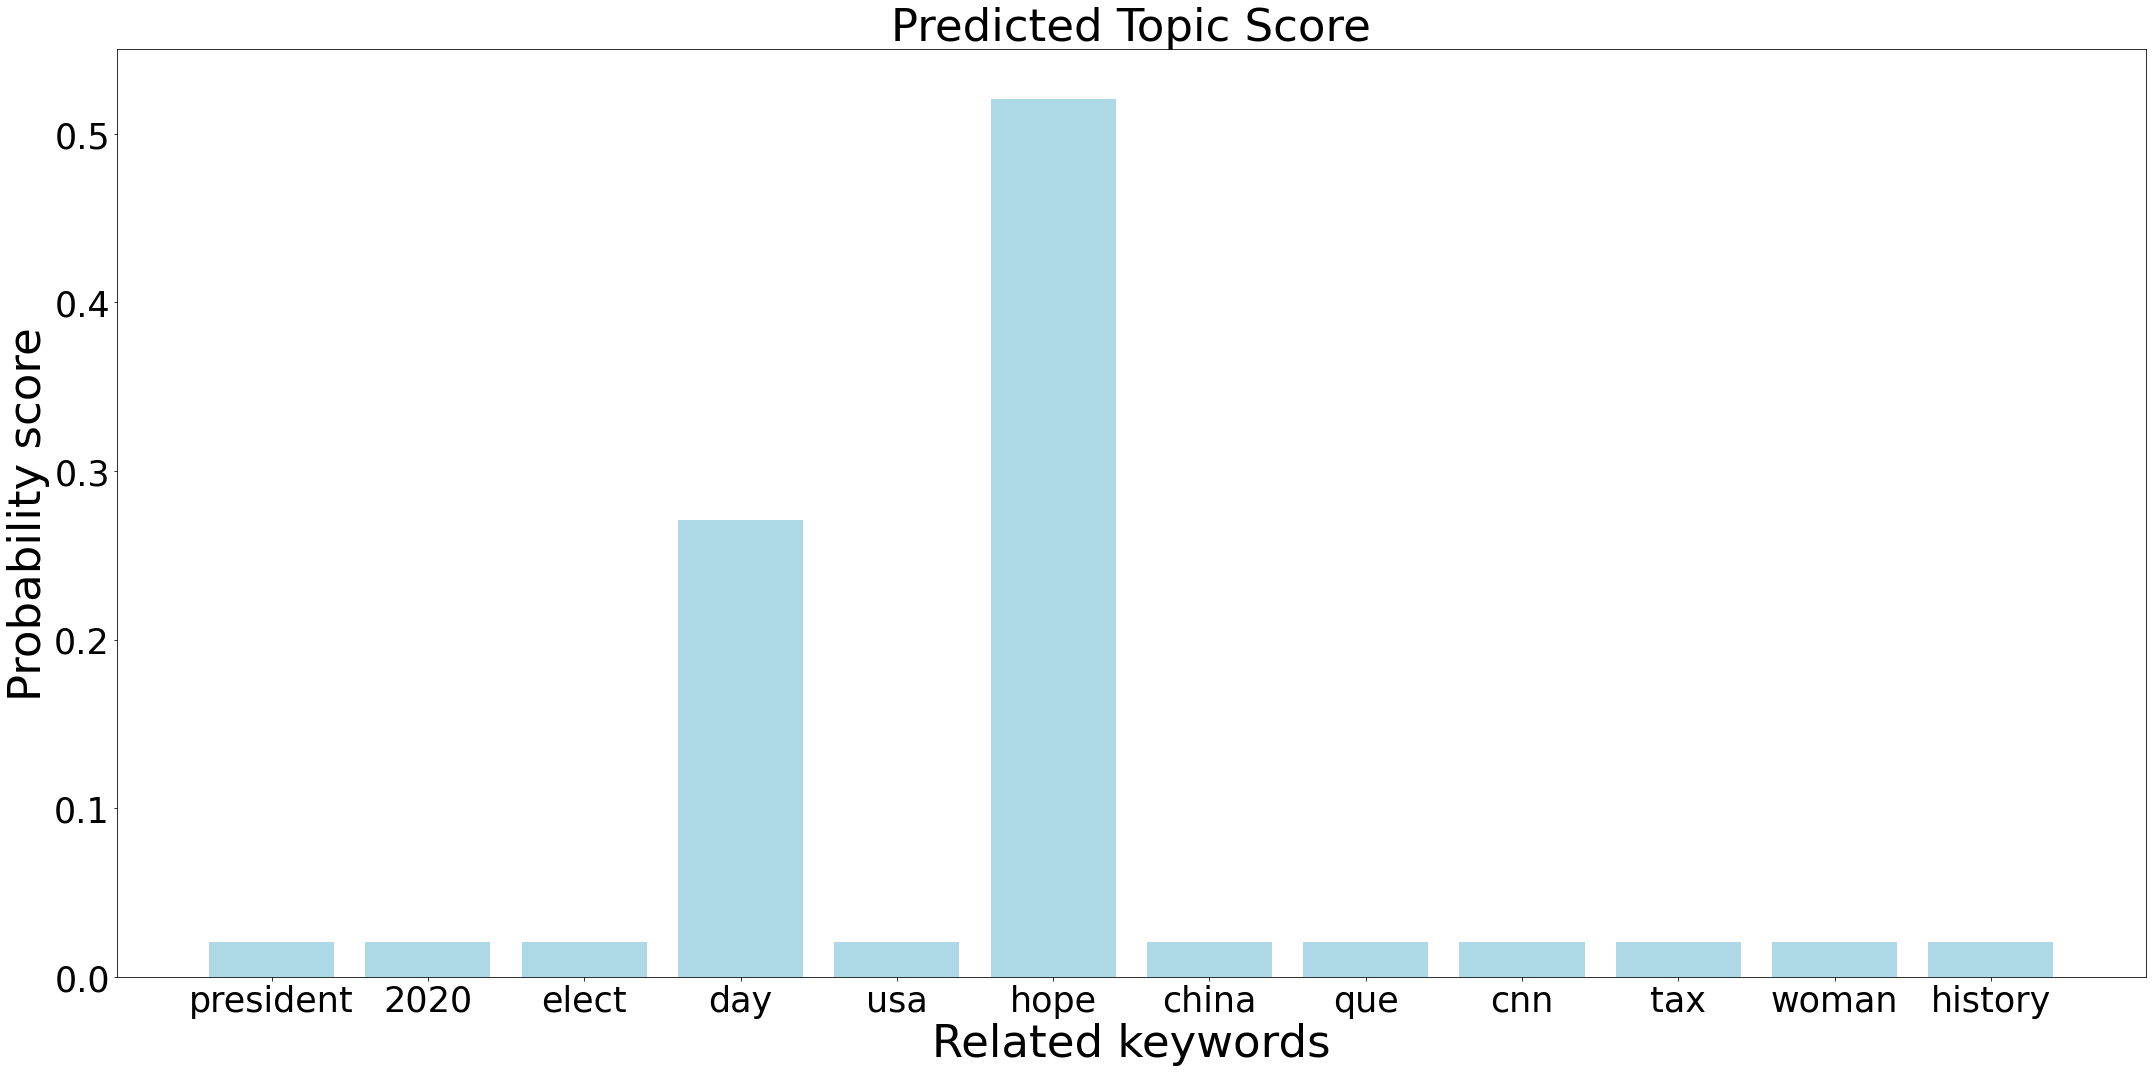

In [ ]:
# Predict the topic
mytext =  ["Biden is the best president for this country vote for him"]
topic, prob_scores = predict_topic(text = mytext)
fig, ax = plt.subplots(figsize=(30,15))
plt.bar(topic[:12], prob_scores[0], color = 'lightblue')
axes = plt.gca()
axes.set_ylim(0, 0.55)
plt.xlabel('Related keywords', size = 45)
plt.ylabel('Probability score', size = 45)
plt.title('Predicted Topic Score', size = 45)
plt.xticks(size = 35)
plt.yticks(size = 35)

fig.tight_layout()
plt.show()

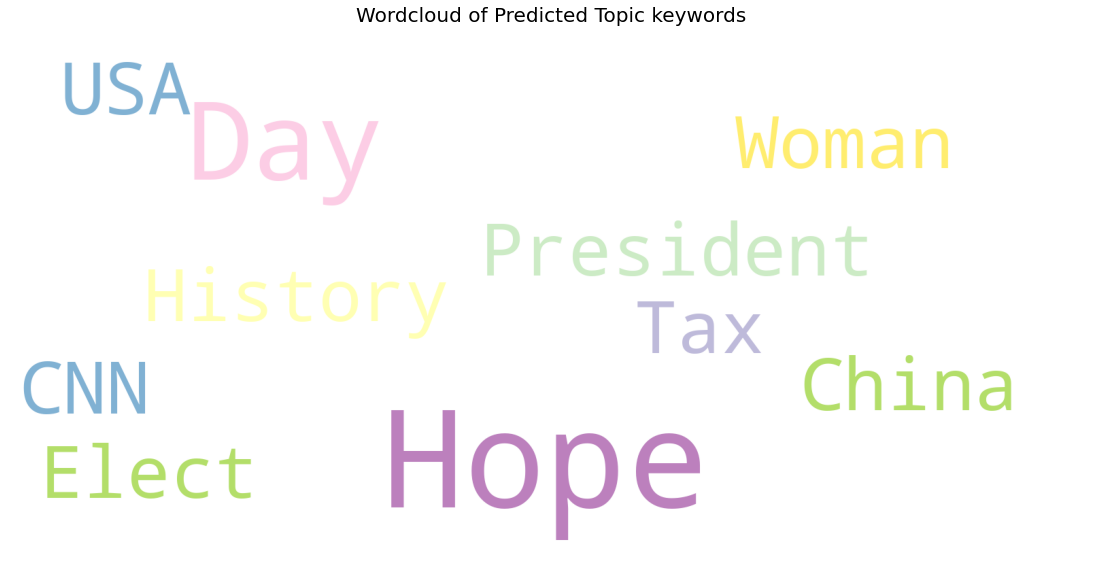

In [ ]:
# generating wordcloud of the predicted topic keywords 
text_topic6= ("President 2020 Elect Day Day Day USA Hope Hope Hope Hope Hope China CNN Tax Woman History")

# Create and generate a word cloud image:
wordcloud = WordCloud(width=1600, height=800, max_font_size=200, max_words=100, colormap = 'Set3', background_color="white", collocations=True).generate(text_topic6)

# Display the generated image:
plt.figure(figsize=(20,10))
plt.imshow(wordcloud)
plt.title('Wordcloud of Predicted Topic keywords', size = 20)
plt.axis("off")
plt.show()

New tweet has been allocated to the topic that has HOPE and DAY related keywords.

In [ ]:
# Predict the topic
mytext = ["CNN lies to people"]
topic, prob_scores = predict_topic(text = mytext)
fig, ax = plt.subplots(figsize=(35,15))
plt.bar(topic[:12], prob_scores[0], color = 'lightblue')
axes = plt.gca()
axes.set_ylim(0, .4)
plt.xlabel('Related keywords', size = 45)
plt.ylabel('Probability score', size = 45)
plt.title('Predicted Topic Score', size = 45)
plt.xticks(size = 35)
plt.yticks(size = 35)


fig.tight_layout()
plt.show()

NameError: name 'predict_topic' is not defined

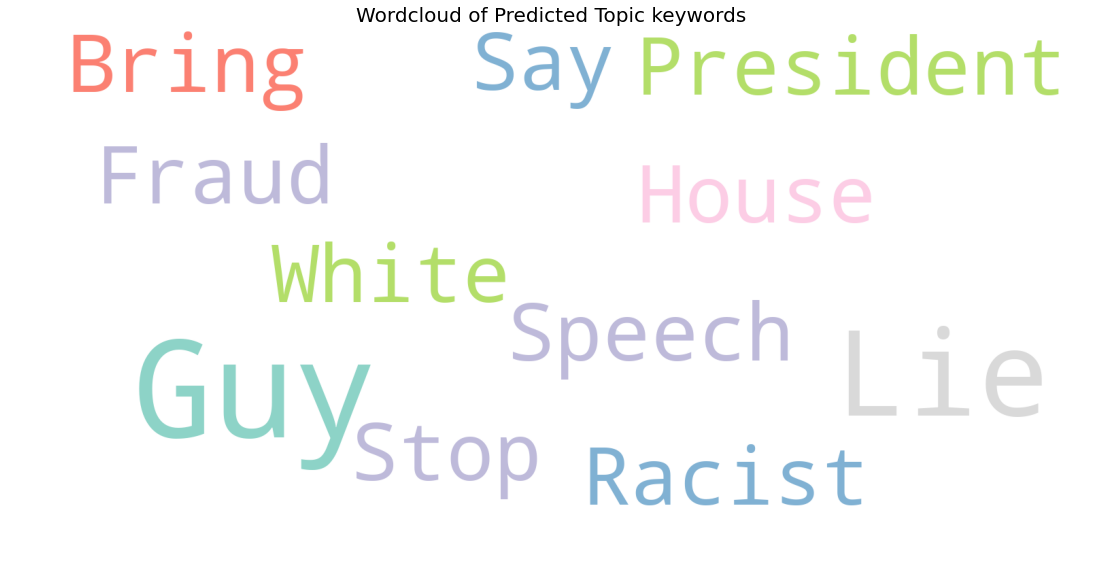

In [ ]:
# generating wordcloud of the predicted topic keywords
text_topic8= ("President Lie Lie Lie  White House Speech Say Guy Guy Guy Guy Fraud Racist Stop Bring")
# Create and generate a word cloud image:
wordcloud = WordCloud(width=1600, height=800, max_font_size=200, max_words=100, colormap = 'Set3', background_color="white", collocations=True).generate(text_topic8)

# Display the generated image:
plt.figure(figsize=(20,10))
plt.imshow(wordcloud)
plt.title('Wordcloud of Predicted Topic keywords', size = 20)
plt.axis("off")
plt.show()

New tweet has been allocated to the topic that has LIE and GUY related keywords.

## 6. Geographical Analysis over Topic and popularity

**1. Prediction for president:** In which states is Joe Biden behind Trump and by how much?

In [ ]:
twitter_usa_df.head()

,created_at,tweet_id,tweet,Likes,Retweets,source,user_id,Followers,user_location,lat,...,city,country,continent,State,state_code,initial_dataset,clean_tweets,tokenize_tweets,lemmat_tweets,Topic
0,2020-10-15 00:00:02,1.316529e+18,"#Trump: As a student I used to hear for years,...",2.0,1.0,Twitter Web App,8.436472e+06,1185.0,Portland,45.520247,...,Portland,United States,North America,Oregon,OR,trump,student hear years years heard china 2019 1 ...,"[student, hear, years, years, heard, china, 20...",student hear year year heard china 2019 1 5 kn...,5
1,2020-10-15 00:00:08,1.316529e+18,You get a tie! And you get a tie! #Trump ‘s ra...,4.0,3.0,Twitter for iPhone,4.741380e+07,5393.0,Washington DC,38.894992,...,Washington,United States,North America,District of Columbia,DC,trump,tie tie rally iowa,"[tie, tie, rally, iowa]",tie tie rally iowa,0
3,2020-10-15 00:00:26,1.316529e+18,#Trump #PresidentTrump #Trump2020LandslideVict...,3.0,5.0,Twitter for Android,1.243315e+18,496.0,"San Diego, CA",32.717421,...,San Diego,United States,North America,California,CA,trump,president maga kag 4moreyears america a...,"[president, maga, kag, 4moreyears, america, am...",president maga kag 4moreyears america americaf...,4
4,2020-10-15 00:01:14,1.316530e+18,"#Trump: Nobody likes to tell you this, but som...",1.0,1.0,Twitter Web App,8.436472e+06,1185.0,Portland,45.520247,...,Portland,United States,North America,Oregon,OR,trump,likes tell farmers better way working asses ...,"[likes, tell, farmers, better, way, working, a...",like tell farmer well way work ass check total...,2
6,2020-10-15 00:01:30,1.316530e+18,@karatblood @KazePlays_JC Grab @realDonaldTrum...,2.0,0.0,Twitter for iPhone,3.602439e+07,1952.0,"Western Washington, USA",41.882823,...,Chicago,United States,North America,Illinois,IL,trump,_jc grab balls chuck bastard door pennsylvania...,"[_jc, grab, balls, chuck, bastard, door, penns...",_jc grab ball chuck bastard door pennsylvaniaa...,0


In [ ]:
# Add compound rate of tweets from trump and biden dataset to the combined dataset
#sentiment_trump_biden = trump_usa_df[['tweet_id', 'comp_score','compound','initial_dataset']].append(biden_usa_df[['tweet_id', 'comp_score','compound','initial_dataset']])
twitter_usa_df_geo_topic = twitter_usa_df[['tweet_id','tweet', 'Topic','State','user_id','vader_sentiment','vader_polarity','initial_dataset']]

In [ ]:
twitter_usa_df_geo_topic.head()

,tweet_id,tweet,Topic,State,user_id,comp_score,compound,initial_dataset
0,1.316529e+18,"#Trump: As a student I used to hear for years,...",5,Oregon,8.436472e+06,positive,0.4738,trump
1,1.316529e+18,You get a tie! And you get a tie! #Trump ‘s ra...,0,District of Columbia,4.741380e+07,neutral,0.0000,trump
2,1.316529e+18,#Trump #PresidentTrump #Trump2020LandslideVict...,4,California,1.243315e+18,neutral,0.0000,trump
3,1.316530e+18,"#Trump: Nobody likes to tell you this, but som...",2,Oregon,8.436472e+06,positive,0.7278,trump
4,1.316530e+18,@karatblood @KazePlays_JC Grab @realDonaldTrum...,0,Illinois,3.602439e+07,negative,-0.6229,trump


In [ ]:
# Combute the mean compound score per president elect over each state 
twitter_president_states_score = twitter_usa_df_geo_topic.groupby(['State', 'initial_dataset'])['vader_polarity'].mean().unstack(level=1, fill_value=0).reset_index()

In [ ]:
twitter_president_states_score.head()

initial_dataset,State,biden,trump
0,Alabama,0.085881,-0.007142
1,Alaska,0.117367,-0.093488
2,Arizona,0.087870,-0.010395
3,Arkansas,0.176700,0.006891
4,California,0.119571,-0.000917


In [ ]:
# To know how far Biden is behind or before Trump in each state let's compute the difference 'Biden - Trump'
twitter_president_states_score['difference_score'] = twitter_president_states_score['biden'] - twitter_president_states_score['trump']
twitter_president_states_score.head()

initial_dataset,State,biden,trump,difference_score
0,Alabama,0.085881,-0.007142,0.093023
1,Alaska,0.117367,-0.093488,0.210855
2,Arizona,0.087870,-0.010395,0.098265
3,Arkansas,0.176700,0.006891,0.169809
4,California,0.119571,-0.000917,0.120488


In [ ]:
# check geojson file
#geo_usa_df = geo_usa_df.drop(columns=['trump_states_cnt','biden_states_cnt','src_max_tweets'])
geo_usa_df.head()

,type,features,GEO_ID,STATE,State,CENSUSAREA,geometry
0,FeatureCollection,"{'type': 'Feature', 'properties': {'GEO_ID': '...",0400000US23,23,Maine,30842.923,"{'type': 'MultiPolygon', 'coordinates': [[[[-6..."
1,FeatureCollection,"{'type': 'Feature', 'properties': {'GEO_ID': '...",0400000US25,25,Massachusetts,7800.058,"{'type': 'MultiPolygon', 'coordinates': [[[[-7..."
2,FeatureCollection,"{'type': 'Feature', 'properties': {'GEO_ID': '...",0400000US26,26,Michigan,56538.901,"{'type': 'MultiPolygon', 'coordinates': [[[[-8..."
3,FeatureCollection,"{'type': 'Feature', 'properties': {'GEO_ID': '...",0400000US30,30,Montana,145545.801,"{'type': 'Polygon', 'coordinates': [[[-104.057..."
4,FeatureCollection,"{'type': 'Feature', 'properties': {'GEO_ID': '...",0400000US32,32,Nevada,109781.180,"{'type': 'Polygon', 'coordinates': [[[-114.050..."


In [ ]:
#Add difference score feature to the geo dataframe
geo_usa_df = pd.merge(geo_usa_df, twitter_president_states_score[['State','difference_score']], on='State')
geo_usa_df.head()

,type,features,GEO_ID,STATE,State,CENSUSAREA,geometry,difference_score_x,difference_score_y,difference_score
0,FeatureCollection,"{'type': 'Feature', 'properties': {'GEO_ID': '...",0400000US23,23,Maine,30842.923,"{'type': 'MultiPolygon', 'coordinates': [[[[-6...",-0.168600,-0.168600,-0.168600
1,FeatureCollection,"{'type': 'Feature', 'properties': {'GEO_ID': '...",0400000US25,25,Massachusetts,7800.058,"{'type': 'MultiPolygon', 'coordinates': [[[[-7...",0.137152,0.137152,0.137152
2,FeatureCollection,"{'type': 'Feature', 'properties': {'GEO_ID': '...",0400000US26,26,Michigan,56538.901,"{'type': 'MultiPolygon', 'coordinates': [[[[-8...",0.171730,0.171730,0.171730
3,FeatureCollection,"{'type': 'Feature', 'properties': {'GEO_ID': '...",0400000US30,30,Montana,145545.801,"{'type': 'Polygon', 'coordinates': [[[-104.057...",0.099484,0.099484,0.099484
4,FeatureCollection,"{'type': 'Feature', 'properties': {'GEO_ID': '...",0400000US32,32,Nevada,109781.180,"{'type': 'Polygon', 'coordinates': [[[-114.050...",0.129796,0.129796,0.129796


![](prediction_president.png) 

**2. Prediction for topic:** What topic is each state more interested in?

In [ ]:
twitter_usa_df_geo_topic.head()

,tweet_id,tweet,Topic,State,user_id,comp_score,compound,initial_dataset
0,1.316529e+18,"#Trump: As a student I used to hear for years,...",5,Oregon,8.436472e+06,positive,0.4738,trump
1,1.316529e+18,You get a tie! And you get a tie! #Trump ‘s ra...,0,District of Columbia,4.741380e+07,neutral,0.0000,trump
2,1.316529e+18,#Trump #PresidentTrump #Trump2020LandslideVict...,4,California,1.243315e+18,neutral,0.0000,trump
3,1.316530e+18,"#Trump: Nobody likes to tell you this, but som...",2,Oregon,8.436472e+06,positive,0.7278,trump
4,1.316530e+18,@karatblood @KazePlays_JC Grab @realDonaldTrum...,0,Illinois,3.602439e+07,negative,-0.6229,trump


In [ ]:
# Group by compound mean per state and topic
df_compoundMean_state_topic = twitter_usa_df_geo_topic.groupby(['State', 'Topic']).agg({'vader_polarity':'mean'}).reset_index()

# Group by topic to find max relevant topic per State
df_maxTopic_state = twitter_usa_df_geo_topic.groupby(['State', 'Topic'])['Topic'].count().sort_values().groupby(level=0).tail(1).reset_index(name='count')

In [ ]:
# Merge the two dataframes to find the mean compounf score for the max Topic per State
df_state_compound_maxTopic = pd.merge(df_maxTopic_state, df_compoundMean_state_topic, on=['State', 'Topic']).drop(columns=['count'])
df_state_compound_maxTopic.head()

,State,Topic,compound
0,South Dakota,6,0.081100
1,Wyoming,7,-0.186250
2,Maine,6,0.220520
3,West Virginia,10,0.072086
4,New Hampshire,2,0.044350


In [ ]:
#Add topic and compound score to the geo dataframe
geo_usa_df = pd.merge(geo_usa_df, df_state_compound_maxTopic[['State','Topic','vader_polarity']], on='State')
geo_usa_df.head()

,type,features,GEO_ID,STATE,State,CENSUSAREA,geometry,difference_score_x,difference_score_y,difference_score,Topic,compound
0,FeatureCollection,"{'type': 'Feature', 'properties': {'GEO_ID': '...",0400000US23,23,Maine,30842.923,"{'type': 'MultiPolygon', 'coordinates': [[[[-6...",-0.168600,-0.168600,-0.168600,6,0.220520
1,FeatureCollection,"{'type': 'Feature', 'properties': {'GEO_ID': '...",0400000US25,25,Massachusetts,7800.058,"{'type': 'MultiPolygon', 'coordinates': [[[[-7...",0.137152,0.137152,0.137152,2,-0.020830
2,FeatureCollection,"{'type': 'Feature', 'properties': {'GEO_ID': '...",0400000US26,26,Michigan,56538.901,"{'type': 'MultiPolygon', 'coordinates': [[[[-8...",0.171730,0.171730,0.171730,1,-0.070527
3,FeatureCollection,"{'type': 'Feature', 'properties': {'GEO_ID': '...",0400000US30,30,Montana,145545.801,"{'type': 'Polygon', 'coordinates': [[[-104.057...",0.099484,0.099484,0.099484,1,0.050633
4,FeatureCollection,"{'type': 'Feature', 'properties': {'GEO_ID': '...",0400000US32,32,Nevada,109781.180,"{'type': 'Polygon', 'coordinates': [[[-114.050...",0.129796,0.129796,0.129796,0,0.033354


In [ ]:
#geo_usa_df.to_json('geo_usa_df_topics.json',orient='records')

![](topic_state.png) 

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=2ad9d46f-2808-4b2f-abb2-ebcdbc6db4dd' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>